# Swin Transformer Functions

Import

In [1]:
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch
from bisect import bisect
import torch.nn.functional as F
import numpy as np
from random import choice

from torch.utils.data import Dataset
from PIL import Image
# import cv2
import os
import struct
from glob import glob
from torchvision import transforms, datasets
from torch.utils.data.dataset import Dataset
import math
import torch.utils.data as data

import random
import logging
import time

from datetime import datetime
import torchvision

import torch.optim as optim

import matplotlib.pyplot as plt

Swinjscc

In [2]:
# Modules

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, add_token=True, token_num=0, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape

        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))  # (N+1)x(N+1)

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww

        if add_token:
            attn[:, :, token_num:, token_num:] = attn[:, :, token_num:, token_num:] + relative_position_bias.unsqueeze(
                0)
        else:
            attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            if add_token:
                # padding mask matrix
                mask = F.pad(mask, (token_num, 0, token_num, 0), "constant", 0)
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm

    """

    def __init__(self, input_resolution, dim, out_dim=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        if out_dim is None:
            out_dim = dim
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, out_dim, bias=False)
        self.norm = norm_layer(4 * dim)
        # self.proj = nn.Conv2d(dim, out_dim, kernel_size=2, stride=2)
        # self.norm = nn.LayerNorm(out_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        # print(x.shape)
        # print(self.input_resolution)
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, H*W//4, 4 * C)  # B H/2*W/2 4*C
        x = self.norm(x)
        x = self.reduction(x)

        # x = x.view(B, H, W, C).permute(0, 3, 1, 2)
        # x = self.proj(x).flatten(2).transpose(1, 2)
        # x = self.norm(x)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class PatchMerging4x(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm, use_conv=False):
        super().__init__()
        H, W = input_resolution
        self.patch_merging1 = PatchMerging((H, W), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)
        self.patch_merging2 = PatchMerging((H // 2, W // 2), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)

    def forward(self, x, H=None, W=None):
        if H is None:
            H, W = self.input_resolution
        x = self.patch_merging1(x, H, W)
        x = self.patch_merging2(x, H//2, W//2)
        return x


class PatchReverseMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm

    """

    def __init__(self, input_resolution, dim, out_dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.out_dim = out_dim
        self.increment = nn.Linear(dim, out_dim * 4, bias=False)
        self.norm = norm_layer(dim)
        # self.proj = nn.ConvTranspose2d(dim // 4, 3, 3, stride=1, padding=1)
        # self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = self.norm(x)
        x = self.increment(x)
        x = x.view(B, H, W, -1).permute(0, 3, 1, 2)
        x = nn.PixelShuffle(2)(x)
        # x = self.proj(x).flatten(2).transpose(1, 2)
        # x = self.norm(x)
        # print(x.shape)
        x = x.flatten(2).permute(0, 2, 1)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * 2 * W * 2 * self.dim // 4
        flops += (H * 2) * (W * 2) * self.dim // 4 * self.dim
        return flops


class PatchReverseMerging4x(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm, use_conv=False):
        super().__init__()
        self.use_conv = use_conv
        self.input_resolution = input_resolution
        self.dim = dim
        H, W = input_resolution
        self.patch_reverse_merging1 = PatchReverseMerging((H, W), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)
        self.patch_reverse_merging2 = PatchReverseMerging((H * 2, W * 2), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)

    def forward(self, x, H=None, W=None):
        if H is None:
            H, W = self.input_resolution
        x = self.patch_reverse_merging1(x, H, W)
        x = self.patch_reverse_merging2(x, H*2, W*2)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * 2 * W * 2 * self.dim // 4
        flops += (H * 2) * (W * 2) * self.dim // 4 * self.dim
        return flops


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #     f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


# Encoder

class SwinTransformerBlock(nn.Module):

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,

                 mlp_ratio=4., qkv_bias=True, qk_scale=None, act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):

        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C
        B_, N, C = x_windows.shape

        # merge windows
        attn_windows = self.attn(x_windows,
                                 add_token=False,
                                 mask=self.attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

    def update_mask(self):
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
            self.attn_mask = attn_mask.to(device)
        else:
            pass


class BasicLayer(nn.Module):
    def __init__(self, dim, out_dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm,
                 downsample=None):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=out_dim,
                                 input_resolution=(input_resolution[0] // 2, input_resolution[1] // 2),
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, out_dim=out_dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        if self.downsample is not None:
            x = self.downsample(x)
        for _, blk in enumerate(self.blocks):
            x = blk(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

    def update_resolution(self, H, W):
        for _, blk in enumerate(self.blocks):
            blk.input_resolution = (H, W)
            blk.update_mask()
        if self.downsample is not None:
            self.downsample.input_resolution = (H * 2, W * 2)

class AdaptiveModulator(nn.Module):
    def __init__(self, M):
        super(AdaptiveModulator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, M),
            nn.ReLU(),
            nn.Linear(M, M),
            nn.ReLU(),
            nn.Linear(M, M),
            nn.Sigmoid()
        )

    def forward(self, snr):
        return self.fc(snr)

class SwinJSCC_Encoder(nn.Module):
    def __init__(self, img_size, patch_size, in_chans,
                 embed_dims, depths, num_heads, C,
                 window_size=4, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 bottleneck_dim=16):
        super().__init__()
        self.num_layers = len(depths)
        self.patch_norm = patch_norm
        self.num_features = bottleneck_dim
        self.mlp_ratio = mlp_ratio
        self.embed_dims = embed_dims
        self.in_chans = in_chans
        self.patch_size = patch_size
        self.patches_resolution = img_size
        self.H = img_size[0] // (2 ** self.num_layers)
        self.W = img_size[1] // (2 ** self.num_layers)
        self.patch_embed = PatchEmbed(img_size, 2, 3, embed_dims[0])
        self.hidden_dim = int(self.embed_dims[len(embed_dims)-1] * 1.5)
        self.layer_num = layer_num = 7

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dims[i_layer - 1]) if i_layer != 0 else 3,
                               out_dim=int(embed_dims[i_layer]),
                               input_resolution=(self.patches_resolution[0] // (2 ** i_layer),
                                                 self.patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               norm_layer=norm_layer,
                               downsample=PatchMerging if i_layer != 0 else None)
            print("Encoder ", layer.extra_repr())
            self.layers.append(layer)
        self.norm = norm_layer(embed_dims[-1])
        if C != None:
            self.head_list = nn.Linear(embed_dims[-1], C)
        self.apply(self._init_weights)

        self.bm_list = nn.ModuleList()
        self.sm_list = nn.ModuleList()
        self.sm_list.append(nn.Linear(self.embed_dims[len(embed_dims) - 1], self.hidden_dim))
        for i in range(layer_num):
            if i == layer_num - 1:
                outdim = self.embed_dims[len(embed_dims) - 1]
            else:
                outdim = self.hidden_dim
            self.bm_list.append(AdaptiveModulator(self.hidden_dim))
            self.sm_list.append(nn.Linear(self.hidden_dim, outdim))
        self.sigmoid = nn.Sigmoid()

        self.bm_list1 = nn.ModuleList()
        self.sm_list1 = nn.ModuleList()
        self.sm_list1.append(nn.Linear(self.embed_dims[len(embed_dims) - 1], self.hidden_dim))
        for i in range(layer_num):
            if i == layer_num - 1:
                outdim = self.embed_dims[len(embed_dims) - 1]
            else:
                outdim = self.hidden_dim
            self.bm_list1.append(AdaptiveModulator(self.hidden_dim))
            self.sm_list1.append(nn.Linear(self.hidden_dim, outdim))
        self.sigmoid1 = nn.Sigmoid()


    def forward(self, x, snr, rate, model):
        
        
        
        B, C, H, W = x.size()
        #device = x.get_device()
        if x.is_cuda:
            device = x.get_device()
        else:
            device = 'cpu'
        
        x = self.patch_embed(x)
        for i_layer, layer in enumerate(self.layers):
            x = layer(x)
            print(x.mean())
        x = self.norm(x)

        if model == 'SwinJSCC_w/o_SAandRA':
            x = self.head_list(x)
            return x

        elif model == 'SwinJSCC_w/_SA':
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)

                bm = self.bm_list[i](snr_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            x = self.head_list(x)
            return x

        elif model == 'SwinJSCC_w/_RA':
            rate_cuda = torch.tensor(rate, dtype=torch.float).to(device)
            rate_batch = rate_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)

                bm = self.bm_list[i](rate_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            mask = torch.sum(mod_val, dim=1)
            sorted, indices = mask.sort(dim=1, descending=True)
            c_indices = indices[:, :rate]
            add = torch.Tensor(range(0, B * x.size()[2], x.size()[2])).unsqueeze(1).repeat(1, rate)
            c_indices = c_indices + add.int().to(device)
            mask = torch.zeros(mask.size()).reshape(-1).to(device)
            mask[c_indices.reshape(-1)] = 1
            mask = mask.reshape(B, x.size()[2])
            mask = mask.unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
            x = x * mask
            return x, mask

        elif model == 'SwinJSCC_w/_SAandRA':
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            rate_cuda = torch.tensor(rate, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            rate_batch = rate_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list1[i](x.detach())
                else:
                    temp = self.sm_list1[i](temp)

                bm = self.bm_list1[i](snr_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val1 = self.sigmoid1(self.sm_list1[-1](temp))
            x = x * mod_val1

            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)

                bm = self.bm_list[i](rate_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            mask = torch.sum(mod_val, dim=1)
            sorted, indices = mask.sort(dim=1, descending=True)
            c_indices = indices[:, :rate]
            add = torch.Tensor(range(0, B * x.size()[2], x.size()[2])).unsqueeze(1).repeat(1, rate)
            c_indices = c_indices + add.int().to(device)
            mask = torch.zeros(mask.size()).reshape(-1).to(device)
            mask[c_indices.reshape(-1)] = 1
            mask = mask.reshape(B, x.size()[2])
            mask = mask.unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)

            x = x * mask
            return x, mask

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        return flops

    def update_resolution(self, H, W):
        self.input_resolution = (H, W)
        for i_layer, layer in enumerate(self.layers):
            layer.update_resolution(H // (2 ** (i_layer + 1)),
                                    W // (2 ** (i_layer + 1)))


def create_encoder(**kwargs):
    model = SwinJSCC_Encoder(**kwargs)
    return model


# Decoder

class BasicLayerDecoder(nn.Module):

    def __init__(self, dim, out_dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 norm_layer=nn.LayerNorm, upsample=None,):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = upsample(input_resolution, dim=dim, out_dim=out_dim, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for _, blk in enumerate(self.blocks):
            x = blk(x)

        if self.upsample is not None:
            x = self.upsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
            print("blk.flops()", blk.flops())
        if self.upsample is not None:
            flops += self.upsample.flops()
            print("upsample.flops()", self.upsample.flops())
        return flops

    def update_resolution(self, H, W):
        self.input_resolution = (H, W)
        for _, blk in enumerate(self.blocks):
            blk.input_resolution = (H, W)
            blk.update_mask()
        if self.upsample is not None:
            self.upsample.input_resolution = (H, W)


class SwinJSCC_Decoder(nn.Module):
    def __init__(self, img_size, embed_dims, depths, num_heads, C,
                 window_size=4, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 bottleneck_dim=16):
        super().__init__()

        self.num_layers = len(depths)
        self.ape = ape
        self.embed_dims = embed_dims
        self.patch_norm = patch_norm
        self.num_features = bottleneck_dim
        self.mlp_ratio = mlp_ratio
        self.H = img_size[0]
        self.W = img_size[1]
        self.patches_resolution = (img_size[0] // 2 ** len(depths), img_size[1] // 2 ** len(depths))
        num_patches = self.H // 4 * self.W // 4
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dims[0]))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayerDecoder(dim=int(embed_dims[i_layer]),
                               out_dim=int(embed_dims[i_layer + 1]) if (i_layer < self.num_layers - 1) else 3,
                               input_resolution=(self.patches_resolution[0] * (2 ** i_layer),
                                                 self.patches_resolution[1] * (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               norm_layer=norm_layer,
                               upsample=PatchReverseMerging)
            self.layers.append(layer)
            print("Decoder ", layer.extra_repr())
        if C != None:
            self.head_list = nn.Linear(C, embed_dims[0])
        self.apply(self._init_weights)
        self.hidden_dim = int(self.embed_dims[0] * 1.5)
        self.layer_num = layer_num = 7
        self.bm_list = nn.ModuleList()
        self.sm_list = nn.ModuleList()
        self.sm_list.append(nn.Linear(self.embed_dims[0], self.hidden_dim))
        for i in range(layer_num):
            if i == layer_num - 1:
                outdim = self.embed_dims[0]
            else:
                outdim = self.hidden_dim
            self.bm_list.append(AdaptiveModulator(self.hidden_dim))
            self.sm_list.append(nn.Linear(self.hidden_dim, outdim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, snr, model):
        if model == 'SwinJSCC_w/o_SAandRA':
            x = self.head_list(x)
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

        elif model == 'SwinJSCC_w/_SA':
            B, L, C = x.size()
            #device = x.get_device()
            if x.is_cuda:
                device = x.get_device()
            else:
                device = 'cpu'
            
            x = self.head_list(x)
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)
                bm = self.bm_list[i](snr_batch).unsqueeze(1).expand(-1, L, -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

        elif model == 'SwinJSCC_w/_RA':
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

        elif model == 'SwinJSCC_w/_SAandRA':
            B, L, C = x.size()
            #device = x.get_device()
            if x.is_cuda:
                device = x.get_device()
            else:
                device = 'cpu'
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)
                bm = self.bm_list[i](snr_batch).unsqueeze(1).expand(-1, L, -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def flops(self):
        flops = 0
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        return flops

    def update_resolution(self, H, W):
        self.input_resolution = (H, W)
        self.H = H * 2 ** len(self.layers)
        self.W = W * 2 ** len(self.layers)
        for i_layer, layer in enumerate(self.layers):
            layer.update_resolution(H * (2 ** i_layer),
                                    W * (2 ** i_layer))


def create_decoder(**kwargs):
    model = SwinJSCC_Decoder(**kwargs)
    return model


# Channel

class Channel(nn.Module):
    """
    Currently the channel model is either error free, erasure channel,
    rayleigh channel or the AWGN channel.
    """

    def __init__(self, args, config):
        super(Channel, self).__init__()
        self.config = config
        self.chan_type = args.channel_type
        self.device = config.device
        self.h = torch.sqrt(torch.randn(1) ** 2
                            + torch.randn(1) ** 2) / 1.414
        if config.logger:
            config.logger.info('【Channel】: Built {} channel, SNR {} dB.'.format(
                args.channel_type, args.multiple_snr))

    def gaussian_noise_layer(self, input_layer, std, name=None):
        #device = input_layer.get_device()
        if input_layer.is_cuda:
            device = input_layer.get_device()
        else:
            device = 'cpu'
        noise_real = torch.normal(mean=0.0, std=std, size=np.shape(input_layer), device=device)
        noise_imag = torch.normal(mean=0.0, std=std, size=np.shape(input_layer), device=device)
        noise = noise_real + 1j * noise_imag
        return input_layer + noise

    def rayleigh_noise_layer(self, input_layer, std, name=None):
        noise_real = torch.normal(mean=0.0, std=std, size=np.shape(input_layer))
        noise_imag = torch.normal(mean=0.0, std=std, size=np.shape(input_layer))
        noise = noise_real + 1j * noise_imag
        h = torch.sqrt(torch.normal(mean=0.0, std=1, size=np.shape(input_layer)) ** 2
                       + torch.normal(mean=0.0, std=1, size=np.shape(input_layer)) ** 2) / np.sqrt(2)
        if self.config.CUDA:
            noise = noise.to(input_layer.get_device())
            h = h.to(input_layer.get_device())
        return input_layer * h + noise


    def complex_normalize(self, x, power):
        pwr = torch.mean(x ** 2) * 2
        out = np.sqrt(power) * x / torch.sqrt(pwr)
        return out, pwr


    def forward(self, input, chan_param, avg_pwr=False):
        if avg_pwr:
            power = 1
            channel_tx = np.sqrt(power) * input / torch.sqrt(avg_pwr * 2)
        else:
            channel_tx, pwr = self.complex_normalize(input, power=1)
        input_shape = channel_tx.shape
        channel_in = channel_tx.reshape(-1)
        L = channel_in.shape[0]
        channel_in = channel_in[:L // 2] + channel_in[L // 2:] * 1j
        channel_output = self.complex_forward(channel_in, chan_param)
        channel_output = torch.cat([torch.real(channel_output), torch.imag(channel_output)])
        channel_output = channel_output.reshape(input_shape)
        if self.chan_type == 1 or self.chan_type == 'awgn':
            noise = (channel_output - channel_tx).detach()
            noise.requires_grad = False
            channel_tx = channel_tx + noise
            if avg_pwr:
                return channel_tx * torch.sqrt(avg_pwr * 2)
            else:
                return channel_tx * torch.sqrt(pwr)
        elif self.chan_type == 2 or self.chan_type == 'rayleigh':
            if avg_pwr:
                return channel_output * torch.sqrt(avg_pwr * 2)
            else:
                return channel_output * torch.sqrt(pwr)

    def complex_forward(self, channel_in, chan_param):
        if self.chan_type == 0 or self.chan_type == 'none':
            return channel_in

        elif self.chan_type == 1 or self.chan_type == 'awgn':
            channel_tx = channel_in
            sigma = np.sqrt(1.0 / (2 * 10 ** (chan_param / 10)))
            chan_output = self.gaussian_noise_layer(channel_tx,
                                                    std=sigma,
                                                    name="awgn_chan_noise")
            return chan_output

        elif self.chan_type == 2 or self.chan_type == 'rayleigh':
            channel_tx = channel_in
            sigma = np.sqrt(1.0 / (2 * 10 ** (chan_param / 10)))
            chan_output = self.rayleigh_noise_layer(channel_tx,
                                                    std=sigma,
                                                    name="rayleigh_chan_noise")
            return chan_output


    def noiseless_forward(self, channel_in):
        channel_tx = self.normalize(channel_in, power=1)
        return channel_tx


# Distortion

@torch.jit.script
def create_window(window_size: int, sigma: float, channel: int):
    '''
    Create 1-D gauss kernel
    :param window_size: the size of gauss kernel
    :param sigma: sigma of normal distribution
    :param channel: input channel
    :return: 1D kernel
    '''
    coords = torch.arange(window_size, dtype=torch.float)
    coords -= window_size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    g = g.reshape(1, 1, 1, -1).repeat(channel, 1, 1, 1)
    return g


@torch.jit.script
def _gaussian_filter(x, window_1d, use_padding: bool):
    '''
    Blur input with 1-D kernel
    :param x: batch of tensors to be blured
    :param window_1d: 1-D gauss kernel
    :param use_padding: padding image before conv
    :return: blured tensors
    '''
    C = x.shape[1]
    padding = 0
    if use_padding:
        window_size = window_1d.shape[3]
        padding = window_size // 2
    out = F.conv2d(x, window_1d, stride=1, padding=(0, padding), groups=C)
    out = F.conv2d(out, window_1d.transpose(2, 3), stride=1, padding=(padding, 0), groups=C)
    return out


@torch.jit.script
def ssim(X, Y, window, data_range: float, use_padding: bool = False):
    '''
    Calculate ssim index for X and Y
    :param X: images
    :param Y: images
    :param window: 1-D gauss kernel
    :param data_range: value range of input images. (usually 1.0 or 255)
    :param use_padding: padding image before conv
    :return:
    '''

    K1 = 0.01
    K2 = 0.03
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    mu1 = _gaussian_filter(X, window, use_padding)
    mu2 = _gaussian_filter(Y, window, use_padding)
    sigma1_sq = _gaussian_filter(X * X, window, use_padding)
    sigma2_sq = _gaussian_filter(Y * Y, window, use_padding)
    sigma12 = _gaussian_filter(X * Y, window, use_padding)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (sigma1_sq - mu1_sq)
    sigma2_sq = compensation * (sigma2_sq - mu2_sq)
    sigma12 = compensation * (sigma12 - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    # Fixed the issue that the negative value of cs_map caused ms_ssim to output Nan.
    cs_map = F.relu(cs_map)
    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    ssim_val = ssim_map.mean(dim=(1, 2, 3))  # reduce along CHW
    cs = cs_map.mean(dim=(1, 2, 3))

    return ssim_val, cs


@torch.jit.script
def ms_ssim(X, Y, window, data_range: float, weights, use_padding: bool = False, eps: float = 1e-8):
    '''
    interface of ms-ssim
    :param X: a batch of images, (N,C,H,W)
    :param Y: a batch of images, (N,C,H,W)
    :param window: 1-D gauss kernel
    :param data_range: value range of input images. (usually 1.0 or 255)
    :param weights: weights for different levels
    :param use_padding: padding image before conv
    :param eps: use for avoid grad nan.
    :return:
    '''
    weights = weights[:, None]

    levels = weights.shape[0]
    vals = []
    for i in range(levels):
        ss, cs = ssim(X, Y, window=window, data_range=data_range, use_padding=use_padding)

        if i < levels - 1:
            vals.append(cs)
            X = F.avg_pool2d(X, kernel_size=2, stride=2, ceil_mode=True)
            Y = F.avg_pool2d(Y, kernel_size=2, stride=2, ceil_mode=True)
        else:
            vals.append(ss)

    vals = torch.stack(vals, dim=0)
    # Use for fix a issue. When c = a ** b and a is 0, c.backward() will cause the a.grad become inf.
    vals = vals.clamp_min(eps)
    # The origin ms-ssim op.
    ms_ssim_val = torch.prod(vals[:-1] ** weights[:-1] * vals[-1:] ** weights[-1:], dim=0)
    # The new ms-ssim op. But I don't know which is best.
    # ms_ssim_val = torch.prod(vals ** weights, dim=0)
    # In this file's image training demo. I feel the old ms-ssim more better. So I keep use old ms-ssim op.
    return ms_ssim_val


class SSIM(torch.jit.ScriptModule):
    __constants__ = ['data_range', 'use_padding']

    def __init__(self, window_size=11, window_sigma=1.5, data_range=255., channel=3, use_padding=False):
        '''
        :param window_size: the size of gauss kernel
        :param window_sigma: sigma of normal distribution
        :param data_range: value range of input images. (usually 1.0 or 255)
        :param channel: input channels (default: 3)
        :param use_padding: padding image before conv
        '''
        super().__init__()
        assert window_size % 2 == 1, 'Window size must be odd.'
        window = create_window(window_size, window_sigma, channel)
        self.register_buffer('window', window)
        self.data_range = data_range
        self.use_padding = use_padding

    @torch.jit.script_method
    def forward(self, X, Y):
        r = ssim(X, Y, window=self.window, data_range=self.data_range, use_padding=self.use_padding)
        return r[0]


class MS_SSIM(torch.jit.ScriptModule):
    __constants__ = ['data_range', 'use_padding', 'eps']

    def __init__(self, window_size=11, window_sigma=1.5, data_range=1.0, channel=3, use_padding=False, weights=None,
                 levels=None, eps=1e-8):
        """
        class for ms-ssim
        :param window_size: the size of gauss kernel
        :param window_sigma: sigma of normal distribution
        :param data_range: value range of input images. (usually 1.0 or 255)
        :param channel: input channels
        :param use_padding: padding image before conv
        :param weights: weights for different levels. (default [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
        :param levels: number of downsampling
        :param eps: Use for fix a issue. When c = a ** b and a is 0, c.backward() will cause the a.grad become inf.
        """
        super().__init__()
        assert window_size % 2 == 1, 'Window size must be odd.'
        self.data_range = data_range
        self.use_padding = use_padding
        self.eps = eps

        window = create_window(window_size, window_sigma, channel)
        self.register_buffer('window', window)

        if weights is None:
            weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
        weights = torch.tensor(weights, dtype=torch.float)

        if levels is not None:
            weights = weights[:levels]
            weights = weights / weights.sum()

        self.register_buffer('weights', weights)

    @torch.jit.script_method
    def forward(self, X, Y):
        return 1 - ms_ssim(X, Y, window=self.window, data_range=self.data_range, weights=self.weights,
                       use_padding=self.use_padding, eps=self.eps)


class MSE(torch.nn.Module):
    def __init__(self, normalization=True):
        super(MSE, self).__init__()
        self.squared_difference = torch.nn.MSELoss(reduction='none')
        self.normalization = normalization

    def forward(self, X, Y):
        # [-1 1] to [0 1]
        if self.normalization:
            X = (X + 1) / 2
            Y = (Y + 1) / 2
        return torch.mean(self.squared_difference(X * 255., Y * 255.))  # / 255.


class Distortion(torch.nn.Module):
    def __init__(self, args):
        super(Distortion, self).__init__()
        if args.distortion_metric == 'MSE':
            self.dist = MSE(normalization=False)
        elif args.distortion_metric == 'SSIM':
            self.dist = SSIM()
        elif args.distortion_metric == 'MS-SSIM':
            if args.trainset == 'CIFAR10':
                self.dist = MS_SSIM(window_size=3, data_range=1., levels=4, channel=3).to(device)
            else:
                self.dist = MS_SSIM(data_range=1., levels=4, channel=3).to(device)
        else:
            args.logger.info("Unknown distortion type!")
            raise ValueError

    def forward(self, X, Y, normalization=False):
        return self.dist.forward(X, Y).mean()  # / 255.


# Network

class SwinJSCC(nn.Module):
    def __init__(self, args, config):
        super(SwinJSCC, self).__init__()
        self.config = config
        encoder_kwargs = config.encoder_kwargs
        decoder_kwargs = config.decoder_kwargs
        self.encoder = create_encoder(**encoder_kwargs)
        self.decoder = create_decoder(**decoder_kwargs)
        if config.logger is not None:
            config.logger.info("Network config: ")
            config.logger.info("Encoder: ")
            config.logger.info(encoder_kwargs)
            config.logger.info("Decoder: ")
            config.logger.info(decoder_kwargs)
        self.distortion_loss = Distortion(args)
        self.channel = Channel(args, config)
        self.pass_channel = config.pass_channel
        self.squared_difference = torch.nn.MSELoss(reduction='none')
        self.H = self.W = 0
        self.multiple_snr = args.multiple_snr.split(",")
        for i in range(len(self.multiple_snr)):
            self.multiple_snr[i] = int(self.multiple_snr[i])
        self.channel_number = args.C.split(",")
        for i in range(len(self.channel_number)):
            self.channel_number[i] = int(self.channel_number[i])
        self.downsample = config.downsample
        self.model = args.model

    def distortion_loss_wrapper(self, x_gen, x_real):
        distortion_loss = self.distortion_loss.forward(x_gen, x_real, normalization=self.config.norm)
        return distortion_loss

    def feature_pass_channel(self, feature, chan_param, avg_pwr=False):
        noisy_feature = self.channel.forward(feature, chan_param, avg_pwr)
        return noisy_feature

    def forward(self, input_image, given_SNR=None, given_rate=None):
        B, _, H, W = input_image.shape

        if H != self.H or W != self.W:
            self.encoder.update_resolution(H, W)
            self.decoder.update_resolution(H // (2 ** self.downsample), W // (2 ** self.downsample))
            self.H = H
            self.W = W

        if given_SNR is None:
            SNR = choice(self.multiple_snr)
            chan_param = SNR
        else:
            chan_param = given_SNR

        if given_rate is None:
            channel_number = choice(self.channel_number)
        else:
            channel_number = given_rate

        if self.model == 'SwinJSCC_w/o_SAandRA' or self.model == 'SwinJSCC_w/_SA':
            feature = self.encoder(input_image, chan_param, channel_number, self.model)
            CBR = feature.numel() / 2 / input_image.numel()
            if self.pass_channel:
                noisy_feature = self.feature_pass_channel(feature, chan_param)
            else:
                noisy_feature = feature

        elif self.model == 'SwinJSCC_w/_RA' or self.model == 'SwinJSCC_w/_SAandRA':
            feature, mask = self.encoder(input_image, chan_param, channel_number, self.model)
            CBR = channel_number / (2 * 3 * 2 ** (self.downsample * 2))
            avg_pwr = torch.sum(feature ** 2) / mask.sum()
            if self.pass_channel:
                noisy_feature = self.feature_pass_channel(feature, chan_param, avg_pwr)
            else:
                noisy_feature = feature
            noisy_feature = noisy_feature * mask

        recon_image = self.decoder(noisy_feature, chan_param, self.model)
        mse = self.squared_difference(input_image * 255., recon_image.clamp(0., 1.) * 255.)
        loss_G = self.distortion_loss.forward(input_image, recon_image.clamp(0., 1.))
        return recon_image, CBR, chan_param, mse.mean(), loss_G.mean()


# Datasets


NUM_DATASET_WORKERS = 8
SCALE_MIN = 0.75
SCALE_MAX = 0.95


class HR_image(Dataset):
    files = {"train": "train", "test": "test", "val": "validation"}

    def __init__(self, config, data_dir):
        self.imgs = []
        for dir in data_dir:
            self.imgs += glob(os.path.join(dir, '*.jpg'))
            self.imgs += glob(os.path.join(dir, '*.png'))
        _, self.im_height, self.im_width = config.image_dims
        self.crop_size = self.im_height
        self.image_dims = (3, self.im_height, self.im_width)
        self.transform = self._transforms()

    def _transforms(self,):
        """
        Up(down)scale and randomly crop to `crop_size` x `crop_size`
        """
        transforms_list = [
            # transforms.RandomCrop((self.im_height, self.im_width)),
            transforms.RandomCrop((256, 256)),
            transforms.ToTensor()]

        return transforms.Compose(transforms_list)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        transformed = self.transform(img)
        return transformed

    def __len__(self):
        return len(self.imgs)


class Datasets(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.imgs = []
        for dir in self.data_dir:
            self.imgs += glob(os.path.join(dir, '*.jpg'))
            self.imgs += glob(os.path.join(dir, '*.png'))
        self.imgs.sort()


    def __getitem__(self, item):
        image_ori = self.imgs[item]
        name = os.path.basename(image_ori)
        image = Image.open(image_ori).convert('RGB')
        self.im_height, self.im_width = image.size
        if self.im_height % 128 != 0 or self.im_width % 128 != 0:
            self.im_height = self.im_height - self.im_height % 128
            self.im_width = self.im_width - self.im_width % 128
        self.transform = transforms.Compose([
            transforms.CenterCrop((self.im_width, self.im_height)),
            transforms.ToTensor()])
        img = self.transform(image)
        return img, name
    def __len__(self):
        return len(self.imgs)

class CIFAR10(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.len = dataset.__len__()

    def __getitem__(self, item):
        return self.dataset.__getitem__(item % self.len)

    def __len__(self):
        return self.len * 10


def get_loader(args, config):
    if args.trainset == 'DIV2K':
        train_dataset = HR_image(config, config.train_data_dir)
        test_dataset = Datasets(config.test_data_dir)
        # test_dataset = HR_image(config, config.test_data_dir)
    elif args.trainset == 'CIFAR10':
        dataset_ = datasets.CIFAR10
        if config.norm is True:
            transform_train = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        else:
            transform_train = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()])

            transform_test = transforms.Compose([
                transforms.ToTensor()])
        train_dataset = dataset_(root=config.train_data_dir,
                                 train=True,
                                 transform=transform_train,
                                 download=False)

        test_dataset = dataset_(root=config.test_data_dir,
                                train=False,
                                transform=transform_test,
                                download=False)

        train_dataset = CIFAR10(train_dataset)

    else:
        train_dataset = Datasets(config.train_data_dir)
        test_dataset = Datasets(config.test_data_dir)

    def worker_init_fn_seed(worker_id):
        seed = 10
        seed += worker_id
        np.random.seed(seed)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               num_workers=NUM_DATASET_WORKERS,
                                               pin_memory=True,
                                               batch_size=config.batch_size,
                                               worker_init_fn=worker_init_fn_seed,
                                               shuffle=True,
                                               drop_last=True)
    if args.trainset == 'CIFAR10':
        test_loader = data.DataLoader(dataset=test_dataset,
                                  batch_size=1024,
                                  shuffle=False)

    else:
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=1,
                                              shuffle=False)

    return train_loader, test_loader


# Utils

class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def clear(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0


def logger_configuration(config, save_log=False, test_mode=False):
    # 配置 logger
    logger = logging.getLogger("Deep joint source channel coder")
    if test_mode:
        config.workdir += '_test'
    if save_log:
        makedirs(config.workdir)
        makedirs(config.samples)
        makedirs(config.models)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s] %(message)s')
    stdhandler = logging.StreamHandler()
    stdhandler.setLevel(logging.INFO)
    stdhandler.setFormatter(formatter)
    logger.addHandler(stdhandler)
    if save_log:
        filehandler = logging.FileHandler(config.log)
        filehandler.setLevel(logging.INFO)
        filehandler.setFormatter(formatter)
        logger.addHandler(filehandler)
    logger.setLevel(logging.INFO)
    config.logger = logger
    return config.logger

def makedirs(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)


def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# Main

def load_weights(model_path):
    pretrained = torch.load(model_path, map_location=device)
    net.load_state_dict(pretrained, strict=False)
    del pretrained

def train_one_epoch(args):
    net.train()
    elapsed, losses, psnrs, msssims, cbrs, snrs = [AverageMeter() for _ in range(6)]
    metrics = [elapsed, losses, psnrs, msssims, cbrs, snrs]
    global global_step
    if args.trainset == 'CIFAR10':
        for batch_idx, (input, label) in enumerate(train_loader):
            start_time = time.time()
            global_step += 1
            input = input.to(device)
            recon_image, CBR, SNR, mse, loss_G = net(input)
            loss = loss_G
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            elapsed.update(time.time() - start_time)
            losses.update(loss.item())
            cbrs.update(CBR)
            snrs.update(SNR)
            if mse.item() > 0:
                psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                psnrs.update(psnr.item())
                msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                msssims.update(msssim)
            else:
                psnrs.update(100)
                msssims.update(100)

            if (global_step % config.print_step) == 0:
                process = (global_step % train_loader.__len__()) / (train_loader.__len__()) * 100.0
                log = (' | '.join([
                    f'Epoch {epoch}',
                    f'Step [{global_step % train_loader.__len__()}/{train_loader.__len__()}={process:.2f}%]',
                    f'Time {elapsed.val:.3f}',
                    f'Loss {losses.val:.3f} ({losses.avg:.3f})',
                    f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                    f'SNR {snrs.val:.1f} ({snrs.avg:.1f})',
                    f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                    f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                    f'Lr {cur_lr}',
                ]))
                logger.info(log)
                for i in metrics:
                    i.clear()
    else:
        for batch_idx, input in enumerate(train_loader):
            start_time = time.time()
            global_step += 1
            input = input.to(device)
            recon_image, CBR, SNR, mse, loss_G = net(input)
            loss = loss_G
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            elapsed.update(time.time() - start_time)
            losses.update(loss.item())
            cbrs.update(CBR)
            snrs.update(SNR)
            if mse.item() > 0:
                psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                psnrs.update(psnr.item())
                msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                msssims.update(msssim)

            else:
                psnrs.update(100)
                msssims.update(100)

            if (global_step % config.print_step) == 0:
                process = (global_step % train_loader.__len__()) / (train_loader.__len__()) * 100.0
                log = (' | '.join([
                    f'Epoch {epoch}',
                    f'Step [{global_step % train_loader.__len__()}/{train_loader.__len__()}={process:.2f}%]',
                    f'Time {elapsed.val:.3f}',
                    f'Loss {losses.val:.3f} ({losses.avg:.3f})',
                    f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                    f'SNR {snrs.val:.1f} ({snrs.avg:.1f})',
                    f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                    f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                    f'Lr {cur_lr}',
                ]))
                logger.info(log)
                for i in metrics:
                    i.clear()
    for i in metrics:
        i.clear()


def test():
    config.isTrain = False
    net.eval()
    elapsed, psnrs, msssims, snrs, cbrs = [AverageMeter() for _ in range(5)]
    metrics = [elapsed, psnrs, msssims, snrs, cbrs]
    multiple_snr = args.multiple_snr.split(",")
    for i in range(len(multiple_snr)):
        multiple_snr[i] = int(multiple_snr[i])
    channel_number = args.C.split(",")
    for i in range(len(channel_number)):
        channel_number[i] = int(channel_number[i])
    results_snr = np.zeros((len(multiple_snr), len(channel_number)))
    results_cbr = np.zeros((len(multiple_snr), len(channel_number)))
    results_psnr = np.zeros((len(multiple_snr), len(channel_number)))
    results_msssim = np.zeros((len(multiple_snr), len(channel_number)))
    for i, SNR in enumerate(multiple_snr):
        for j, rate in enumerate(channel_number):
            with torch.no_grad():
                if args.trainset == 'CIFAR10':
                    for batch_idx, (input, label) in enumerate(test_loader):
                        start_time = time.time()
                        input = input.to(device)
                        recon_image, CBR, SNR, mse, loss_G = net(input, SNR, rate)

                        elapsed.update(time.time() - start_time)
                        cbrs.update(CBR)
                        snrs.update(SNR)
                        if mse.item() > 0:
                            psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                            psnrs.update(psnr.item())
                            msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                            msssims.update(msssim)
                        else:
                            psnrs.update(100)
                            msssims.update(100)

                        log = (' | '.join([
                            f'Time {elapsed.val:.3f}',
                            f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                            f'SNR {snrs.val:.1f}',
                            f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                            f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                            f'Lr {cur_lr}',
                        ]))
                        logger.info(log)
                else:
                    for batch_idx, batch in enumerate(test_loader):
                        input, names = batch
                        start_time = time.time()
                        input = input.to(device)
                        recon_image, CBR, SNR, mse, loss_G = net(input, SNR, rate)
                        torchvision.utils.save_image(recon_image,
                                                     os.path.join("./recon/", f"{names[0]}"))
                        elapsed.update(time.time() - start_time)
                        cbrs.update(CBR)
                        snrs.update(SNR)
                        if mse.item() > 0:
                            psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                            psnrs.update(psnr.item())
                            msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                            msssims.update(msssim)
                            MSSSIM = -10 * math.log10(1 - msssim)
                            print(MSSSIM)
                        else:
                            psnrs.update(100)
                            msssims.update(100)
                        log = (' | '.join([
                            f'Time {elapsed.val:.3f}',
                            f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                            f'SNR {snrs.val:.1f}',
                            f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                            f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                            f'Lr {cur_lr}',
                        ]))
                        logger.info(log)
            results_snr[i, j] = snrs.avg
            results_cbr[i, j] = cbrs.avg
            results_psnr[i, j] = psnrs.avg
            results_msssim[i, j] = msssims.avg
            for t in metrics:
                t.clear()

    print("SNR: {}".format(results_snr.tolist()))
    print("CBR: {}".format(results_cbr.tolist()))
    print("PSNR: {}".format(results_psnr.tolist()))
    print("MS-SSIM: {}".format(results_msssim.tolist()))
    print("Finish Test!")


# Separate Encoder Decoder

def encode_image(input_image, net, given_SNR=None, given_rate=None):
    B, _, H, W = input_image.shape
    net.encoder.update_resolution(H, W)
    net.decoder.update_resolution(H // (2 ** net.downsample), W // (2 ** net.downsample))
    
    chan_snr = given_SNR if given_SNR is not None else choice(net.multiple_snr)
    channel_rate = given_rate if given_rate is not None else choice(net.channel_number)
    
    # Perform encoding
    feature = net.encoder(input_image, chan_snr, channel_rate, net.model)
    
    # Return the encoded feature and channel parameters for later use
    return feature, chan_snr, channel_rate


def pass_through_channel(feature, net, chan_snr, avg_pwr=False):
    if net.pass_channel:
        # Pass through the channel
        noisy_feature = net.channel.forward(feature, chan_snr, avg_pwr)
    else:
        noisy_feature = feature
    return noisy_feature



def decode_image(noisy_feature, net, chan_snr, resolution=(512,768)):
    # Manually update the resolution at the receiver side
    H, W = resolution
    net.decoder.update_resolution(H // (2 ** net.downsample), W // (2 ** net.downsample))
    
    # Perform decoding
    recon_image = net.decoder(noisy_feature, chan_snr, net.model)
    return recon_image


# def save_image(image, filename):
#     torchvision.utils.save_image(image, os.path.join("./recon/", filename))


def load_single_image(image_path, config):
    """
    Load and process a single image, applying transformations.
    
    Args:
        image_path: Path to the input image.
        config: The configuration used for transformations.

    Returns:
        img_tensor: Transformed image tensor ready for the model.
        image_name: The name of the image for saving or logging purposes.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    image_name = os.path.basename(image_path)
    
    # Get the image size and crop to the nearest multiple of 128 (optional, as in your Dataset class)
    im_height, im_width = image.size
    if im_height % 128 != 0 or im_width % 128 != 0:
        im_height = im_height - im_height % 128
        im_width = im_width - im_width % 128

    # Apply the same transformations as in the Datasets class
    transform = transforms.Compose([
        transforms.CenterCrop((im_width, im_height)),
        transforms.ToTensor()
    ])

    img_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
    return img_tensor, image_name


# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1 * 255., img2 * 255.)
    psnr = 10 * torch.log10(255.0 ** 2 / mse)
    return psnr

# Function to plot images
def plot_images(input_image, recon_image, image_name):
    plt.figure(figsize=(20, 10))

    # Plot the input image
    plt.subplot(1, 2, 1)
    plt.imshow(transforms.ToPILImage()(input_image.squeeze(0)))
    plt.title("Original Image")
    #plt.axis('off')

    # Plot the reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(transforms.ToPILImage()(recon_image.squeeze(0)))
    plt.title("Reconstructed Image")
    #plt.axis('off')

    # Show both images
    plt.show()


# Function to plot a single image
def plot_single_image(image):
    plt.figure(figsize=(10, 10))

    # Plot the image
    plt.imshow(transforms.ToPILImage()(image.squeeze(0)))
    plt.title("Reconstructed Image")
    #plt.axis('off')

    # Show the image
    plt.show()



Codebook

In [3]:

def quantize_feature_nd(feature, codebook_nd_torch, chunk_size):
    """
    Quantize a feature [1, M, 32] by splitting into n-d chunks and finding closest codewords.
    feature: [1, M, 32]
    codebook_nd_torch: [K, chunk_size]
    
    Returns indices of shape [M*(32/chunk_size)] (one index per chunk).
    """
    vectors = feature.squeeze(0)  # [M, 32]
    M = vectors.shape[0]

    # Ensure the feature dimension is divisible by chunk_size
    assert vectors.shape[1] % chunk_size == 0, f"Feature size must be divisible by chunk_size={chunk_size}"
    
    # Reshape to [M*(32/chunk_size), chunk_size]
    num_chunks = vectors.shape[1] // chunk_size
    vectors_nd = vectors.view(M * num_chunks, chunk_size)

    # Compute distances to codebook entries
    distances = torch.cdist(vectors_nd.unsqueeze(0), codebook_nd_torch.unsqueeze(0)).squeeze(0)  # [M*(32/chunk_size), K]

    nearest_indices = torch.argmin(distances, dim=1)  # [M*(32/chunk_size)]
    return nearest_indices, M


def dequantize_feature_nd(indices, M, codebook_nd_torch, chunk_size):
    """
    Reconstruct the feature from indices [M*(32/chunk_size)] using the n-d codebook.
    indices: [M*(32/chunk_size)]
    M: the original M dimension
    codebook_nd_torch: [K, chunk_size]

    Returns [1, M, 32]
    """
    # Reconstruct each n-d vector
    reconstructed_nd = codebook_nd_torch[indices]  # [M*(32/chunk_size), chunk_size]

    # Reshape to [M, (32/chunk_size), chunk_size] then to [M, 32]
    num_chunks = 32 // chunk_size
    reconstructed_vectors = reconstructed_nd.view(M, num_chunks, chunk_size).reshape(M, 32)
    reconstructed_feature = reconstructed_vectors.unsqueeze(0)  # [1, M, 32]
    return reconstructed_feature


def run_inference_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size):
    """
    Run inference using the n-d codebook.
    """
    # Load the n-d codebook
    codebook_nd = np.load(codebook_path)  # [K, chunk_size]
    codebook_nd_torch = torch.from_numpy(codebook_nd).float().to(device)
    
    net.eval()
    with torch.no_grad():
        # Load and encode image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        feature, chan_snr, channel_rate = encode_image(input_image, net) # [1, M, 32]
        
        # Quantize feature into n-d chunks
        indices, M = quantize_feature_nd(feature, codebook_nd_torch, chunk_size)
        
        # "Transmit" indices (for demonstration, we just keep them here)
        
        # Dequantize at receiver
        reconstructed_feature = dequantize_feature_nd(indices, M, codebook_nd_torch, chunk_size)
        
        # Decode image
        res = (input_image.shape[2], input_image.shape[3])  # (H, W)
        recon_image = decode_image(reconstructed_feature, net, chan_snr, res)
        
        return recon_image, feature, indices, reconstructed_feature


def encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size):
    """
    Encode image using the n-d codebook.
    """
    # Load the n-d codebook
    codebook_nd = np.load(codebook_path)  # [K, chunk_size]
    codebook_nd_torch = torch.from_numpy(codebook_nd).float().to(device)

    net.eval()
    with torch.no_grad():
        # Load and encode image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        feature, chan_snr, channel_rate = encode_image(input_image, net) # [1, M, 32]

        # Quantize feature into n-d chunks
        indices, M = quantize_feature_nd(feature, codebook_nd_torch, chunk_size)
        
    return indices, M

def decode_image_with_nd_codebook(indices, M, codebook_path, net, res, device, chunk_size, chan_snr=10):
    """
    Decode image from the n-d codebook.
    """

    codebook_nd = np.load(codebook_path)  # [K, chunk_size]
    codebook_nd_torch = torch.from_numpy(codebook_nd).float().to(device)

    # Dequantize at receiver
    reconstructed_feature = dequantize_feature_nd(indices, M, codebook_nd_torch, chunk_size)

    # Decode image
    with torch.no_grad():
        recon_image = decode_image(reconstructed_feature, net, chan_snr, res)

    return recon_image





**main**

In [4]:
save_directories = ["./recon/", "./Binary/Received_Text/", "./Binary/Received_Binary/", "./Binary/Transmitted_Binary/", "./Weights/", "./Datasets/", "./Testing/error correction"]

for save_dir in save_directories:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


**Arguments and Config**

In [5]:
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



class Args:
    def __init__(self):
        self.training = False  # Set to False if testing
        self.trainset = 'DIV2K'  # Choices: ['CIFAR10', 'DIV2K']
        self.testset = 'kodak'  # Choices: ['kodak', 'CLIC21', 'ffhq']
        self.distortion_metric = 'MSE'  # Choices: ['MSE', 'MS-SSIM']
        self.model = 'SwinJSCC_w/o_SAandRA'  # Choices: ['SwinJSCC_w/o_SAandRA', 'SwinJSCC_w/_SA', 'SwinJSCC_w/_RA', 'SwinJSCC_w/_SAandRA']
        self.channel_type = 'awgn'  # Choices: ['awgn', 'rayleigh']
        self.C = '32'  # Bottleneck dimension, any string/number value can be set (32 = 1/48, 64 = 1/24, 96 = 1/16, 128 = 1/12)
        self.multiple_snr = '3'  # Random or fixed SNR, set as string (e.g., '10')
        self.model_size = 'base'  # Choices: ['small', 'base', 'large']

# Initialize the arguments
args = Args()


class config():
    seed = 42
    pass_channel = True
    #CUDA = True
    #device = torch.device("cuda:0")
    CUDA = torch.cuda.is_available()  # Check if CUDA is available
    device = torch.device("cuda:0" if CUDA else "cpu")  # Use GPU if available, otherwise CPU
    norm = False
    # logger
    print_step = 100
    plot_step = 10000
    filename = datetime.now().__str__()[:-7]
    workdir = './history/{}'.format(filename)
    log = workdir + '/Log_{}.log'.format(filename)
    samples = workdir + '/samples'
    models = workdir + '/models'
    logger = None

    # training details
    normalize = False
    learning_rate = 0.0001
    tot_epoch = 10000000

    if args.trainset == 'CIFAR10':
        save_model_freq = 5
        image_dims = (3, 32, 32)
        train_data_dir = "/media/D/Dataset/CIFAR10/"
        test_data_dir = "/media/D/Dataset/CIFAR10/"
        batch_size = 128
        downsample = 2
        channel_number = int(args.C)
        encoder_kwargs = dict(
            img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
            embed_dims=[128, 256], depths=[2, 4], num_heads=[4, 8], C=channel_number,
            window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            norm_layer=nn.LayerNorm, patch_norm=True,
        )
        decoder_kwargs = dict(
            img_size=(image_dims[1], image_dims[2]),
            embed_dims=[256, 128], depths=[4, 2], num_heads=[8, 4], C=channel_number,
            window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            norm_layer=nn.LayerNorm, patch_norm=True,
        )
    elif args.trainset == 'DIV2K':
        save_model_freq = 100
        image_dims = (3, 256, 256)
        # train_data_dir = ["/media/D/Dataset/HR_Image_dataset/"]  
        base_path = "./Datasets/DIV2K"
        if args.testset == 'kodak':
            test_data_dir = ["./Datasets/Kodak"]
        elif args.testset == 'CLIC21':
            test_data_dir = ["/media/D/Dataset/HR_Image_dataset/clic2021/test/"]
        elif args.testset == 'ffhq':
            test_data_dir = ["/media/D/yangke/SwinJSCC/data/ffhq/"]

        train_data_dir = [base_path + '/DIV2K_train_HR/DIV2K_train_HR',
                          base_path + '/DIV2K_valid_HR/DIV2K_valid_HR']


        
        
        batch_size = 16
        downsample = 4
        if args.model == 'SwinJSCC_w/o_SAandRA' or args.model == 'SwinJSCC_w/_SA':
            channel_number = int(args.C)
        else:
            channel_number = None

        if args.model_size == 'small':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 2, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 2, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
        elif args.model_size == 'base':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 6, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 6, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
        elif args.model_size =='large':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 18, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 18, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )

if args.trainset == 'CIFAR10':
    CalcuSSIM = MS_SSIM(window_size=3, data_range=1., levels=4, channel=3).to(device)
else:
    CalcuSSIM = MS_SSIM(data_range=1., levels=4, channel=3).to(device)

**Load Model**

In [6]:
seed_torch()
logger = logger_configuration(config, save_log=False)
logger.info(config.__dict__)
torch.manual_seed(seed=config.seed)

net = SwinJSCC(args, config)
model_path = "./Weights/SwinJSCC_wo_SAandRA_Rayleigh_HRimage_snr3_psnr_C32.model"  
#model_path = "./Weights/SwinJSCC_wo_SAandRA_AWGN_HRimage_snr10_psnr_C32.model" 
load_weights(model_path)
net = net.to(device)



# model_fp32 = SwinJSCC(args, config)
# net = torch.quantization.quantize_dynamic(
#     model_fp32, {torch.nn.Linear}, dtype=torch.qint8
# )
# net.load_state_dict(torch.load("swinjscc_quantized.pt"))
# net = net.to(device)
# net.eval()

2025-05-14 22:41:27,587 - INFO] {'__module__': '__main__', 'seed': 42, 'pass_channel': True, 'CUDA': False, 'device': device(type='cpu'), 'norm': False, 'print_step': 100, 'plot_step': 10000, 'filename': '2025-05-14 22:41:27', 'workdir': './history/2025-05-14 22:41:27', 'log': './history/2025-05-14 22:41:27/Log_2025-05-14 22:41:27.log', 'samples': './history/2025-05-14 22:41:27/samples', 'models': './history/2025-05-14 22:41:27/models', 'logger': <Logger Deep joint source channel coder (INFO)>, 'normalize': False, 'learning_rate': 0.0001, 'tot_epoch': 10000000, 'save_model_freq': 100, 'image_dims': (3, 256, 256), 'base_path': './Datasets/DIV2K', 'test_data_dir': ['./Datasets/Kodak'], 'train_data_dir': ['./Datasets/DIV2K/DIV2K_train_HR/DIV2K_train_HR', './Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR'], 'batch_size': 16, 'downsample': 4, 'channel_number': 32, 'encoder_kwargs': {'img_size': (256, 256), 'patch_size': 2, 'in_chans': 3, 'embed_dims': [128, 192, 256, 320], 'depths': [2, 2, 6,

Encoder  dim=3, input_resolution=(256, 256), depth=2
Encoder  dim=128, input_resolution=(128, 128), depth=2
Encoder  dim=192, input_resolution=(64, 64), depth=6
Encoder  dim=256, input_resolution=(32, 32), depth=2


2025-05-14 22:41:28,122 - INFO] Network config: 
2025-05-14 22:41:28,122 - INFO] Encoder: 
2025-05-14 22:41:28,122 - INFO] {'img_size': (256, 256), 'patch_size': 2, 'in_chans': 3, 'embed_dims': [128, 192, 256, 320], 'depths': [2, 2, 6, 2], 'num_heads': [4, 6, 8, 10], 'C': 32, 'window_size': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'patch_norm': True}
2025-05-14 22:41:28,122 - INFO] Decoder: 
2025-05-14 22:41:28,122 - INFO] {'img_size': (256, 256), 'embed_dims': [320, 256, 192, 128], 'depths': [2, 6, 2, 2], 'num_heads': [10, 8, 6, 4], 'C': 32, 'window_size': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'patch_norm': True}


Decoder  dim=320, input_resolution=(16, 16), depth=2
Decoder  dim=256, input_resolution=(32, 32), depth=6
Decoder  dim=192, input_resolution=(64, 64), depth=2
Decoder  dim=128, input_resolution=(128, 128), depth=2


2025-05-14 22:41:28,138 - INFO] 【Channel】: Built awgn channel, SNR 3 dB.
C:\Users\tharu\AppData\Local\Temp\ipykernel_3192\2695939611.py:1584: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

# Adaptive Patching

In [7]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
import numba

# ---------------------------
# Helper Functions
# ---------------------------
def gaussian_blur(image, kernel_size):
    """Applies Gaussian blur with a square kernel."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def edge_detection(image, tl, th):
    """Converts image to grayscale (if needed) and applies Canny edge detection."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, tl, th)
    # plot the edges image
    # plt.imshow(edges, cmap='gray')
    # plt.title("Edges Image")
    #plt.axis('off')
    # plt.show()
    return edges

def quadtree_partition(edge_img, x, y, w, h, current_depth, max_depth, threshold, min_size=32):
    """
    Recursively partitions the image region [x, y, w, h] using a quadtree.
    Returns a list of patch coordinates (x, y, w, h).
    """
    patches = []
    # Stop if the patch is too small.
    if w <= min_size or h <= min_size:
        patches.append((x, y, w, h))
        return patches

    # Count edge pixels.
    patch_edges = edge_img[y:y+h, x:x+w]
    edge_count = np.count_nonzero(patch_edges)
    
    # Stop subdividing if edge count is low or maximum depth reached.
    if edge_count <= threshold or current_depth >= max_depth:
        patches.append((x, y, w, h))
    else:
        mid_x = x + w // 2
        mid_y = y + h // 2
        # Top-left
        patches += quadtree_partition(edge_img, x, y, mid_x - x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Top-right
        patches += quadtree_partition(edge_img, mid_x, y, x + w - mid_x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-left
        patches += quadtree_partition(edge_img, x, mid_y, mid_x - x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-right
        patches += quadtree_partition(edge_img, mid_x, mid_y, x + w - mid_x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
    return patches

def sort_patches_traditional(patches):
    """
    Sorts patches in traditional reading order: top-to-bottom, left-to-right.
    Each patch is a tuple (x, y, w, h); we sort by y first then x.
    """
    return sorted(patches, key=lambda p: (p[1], p[0]))

def interleave_bits(n):
    """Helper to interleave bits of a 16-bit integer."""
    n &= 0xFFFF
    n = (n | (n << 8)) & 0x00FF00FF
    n = (n | (n << 4)) & 0x0F0F0F0F
    n = (n | (n << 2)) & 0x33333333
    n = (n | (n << 1)) & 0x55555555
    return n

def morton_code(x, y):
    """
    Computes the Morton code (Z-order) for the (x, y) coordinates.
    Here we interleave the bits of x and y.
    """
    return (interleave_bits(y) << 1) | interleave_bits(x)

def sort_patches_by_morton(patches):
    """
    Sorts a list of patch coordinates (x, y, w, h) using the Morton Z-order.
    We compute the Morton code based on the patch’s center.
    """
    patches_with_code = []
    for (x, y, w, h) in patches:
        center_x = x + w // 2
        center_y = y + h // 2
        code = morton_code(center_x, center_y)
        patches_with_code.append(((x, y, w, h), code))
    patches_with_code.sort(key=lambda item: item[1])
    sorted_patches = [item[0] for item in patches_with_code]
    return sorted_patches


# def resize_patch(image, patch, Pm, padding=2):
#     """
#     Extracts the patch (x, y, w, h) from the image and resizes it.
#     First, it resizes the patch to a central region of size (Pm x Pm).
#     Then it creates a padded patch of size (Pm + 2*padding x Pm + 2*padding)
#     where the border is obtained by a simple interpolation.
#     """
#     x, y, w, h = patch
#     patch_img = image[y:y+h, x:x+w]
#     resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)
#     padded_size = Pm + 2 * padding
#     # Initially resize to the padded size (this gives a rough estimate for borders)
#     resized_patch = cv2.resize(patch_img, (padded_size, padded_size), interpolation=cv2.INTER_AREA)
#     # Replace the central region with the correctly resized patch
#     resized_patch[padding:padding+Pm, padding:padding+Pm] = resized_center
#     return resized_patch

def resize_patch(image, patch, Pm, padding=2):
    """
    Extracts the patch (x, y, w, h) from the image and resizes it.
    - Resizes the patch to Pm × Pm for uniform processing.
    - Expands it by padding with edge-aware extensions (mirroring edge pixels).
    - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

    If padding=0, it simply returns the resized patch.
    """
    x, y, w, h = patch
    patch_img = image[y:y+h, x:x+w]

    # Resize patch to Pm × Pm
    resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

    # If padding is 0, return the resized patch directly
    if padding == 0:
        return resized_center

    # Define new padded size
    padded_size = Pm + 2 * padding
    padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

    # Insert resized patch in the center
    padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

    # Edge-aware padding using mirroring or replication
    # Top and bottom padding
    padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
    padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

    # Left and right padding
    padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
    padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

    # Corner regions (copy nearest edge pixels)
    padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
    padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
    padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
    padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

    return padded_patch


def drop_last_or_pad_patch_info(patch_info, L, patch_size, dtype):
    """
    Given a list of patch_info dictionaries, drops extra patches (if > L) or pads with dummy patches
    so that the final list length equals L.
    """
    num = len(patch_info)
    if num > L:
        patch_info = patch_info[:L]  # Keep only the first L patches
    elif num < L:
        # Create a dummy patch (black image)
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((patch_size, patch_size, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((patch_size, patch_size), dtype=dtype)
        for _ in range(L - num):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info

def draw_patch_boundaries(image, patch_info):
    """
    Draws rectangle boundaries on a copy of the image using patch coordinates.
    """
    image_copy = image.copy()
    for info in patch_info:
        x, y, w, h = info['coords']
        # Skip dummy patches.
        if x < 0 or y < 0:
            continue
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 0), 1)
    return image_copy

# def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
#     """
#     Saves grid size, original image shape, and valid patch coordinates to a binary file.
#     """
#     with open(coord_file, "wb") as f:
#         np.array([rows, cols], dtype=np.uint16).tofile(f)  # Grid size
#         np.array(original_shape, dtype=np.uint16).tofile(f)  # Original image shape (H, W, C)
#         valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
#         np.array(valid_coords, dtype=np.uint16).tofile(f)  # Patch coordinates
#     print("Saved patch info to", coord_file)

# def load_patch_info_bin(coord_file):
#     """
#     Loads grid size, original image shape, and patch coordinates from a binary file.
#     """
#     with open(coord_file, "rb") as f:
#         rows, cols = np.fromfile(f, dtype=np.uint16, count=2)
#         original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))
#         coords = np.fromfile(f, dtype=np.uint16).reshape(-1, 4)
#     return coords, rows, cols, original_shape


def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
    """
    Saves grid size, original image shape, number of valid patches, and patch ratio exponents to a binary file.
    
    For each valid patch (where patch_info['coords'][0] >= 0), only one number is saved:
        r_i = log2(H / h_i)
    where H is the original image height and h_i is the patch's height.
    """
    H, W, C = original_shape
    # Filter valid patches (only those with valid coordinates)
    valid_patches = [info for info in patch_info if info['coords'][0] >= 0]
    num_patches = len(valid_patches)

    valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
    
    # Compute ratio exponent for each valid patch (using h from (x, y, w, h))
    ratio_exponents = np.array(
        [int(np.log2(H / info['coords'][3])) for info in valid_patches],
        dtype=np.uint8
    )

    
    with open(coord_file, "wb") as f:
        # Save grid size and original image shape
        np.array([rows, cols], dtype=np.uint16).tofile(f)
        np.array(original_shape, dtype=np.uint16).tofile(f)
        # Save number of valid patches
        np.array([num_patches], dtype=np.uint16).tofile(f)
        # Save the ratio exponents (1 byte per patch)
        ratio_exponents.tofile(f)
    print("Saved minimal patch info to", coord_file)



@numba.njit
def find_free_region(occupancy, H, W, hi, wi, start_y, start_x):
    """
    Scans the occupancy matrix in row-major order starting at (start_y, start_x)
    and returns the first (y, x) position where the region of size (hi, wi) is free.
    Returns (-1, -1) if no free region is found.
    """
    for y in range(start_y, H - hi + 1):
        # When starting in the first candidate row, start x from start_x; otherwise from 0.
        x_start = start_x if y == start_y else 0
        for x in range(x_start, W - wi + 1):
            region_free = True
            for dy in range(hi):
                for dx in range(wi):
                    if occupancy[y + dy, x + dx] != 0:
                        region_free = False
                        break  # break inner dx loop
                if not region_free:
                    break  # break dy loop
            if region_free:
                return y, x
    return -1, -1

@numba.njit
def mark_region(occupancy, y, x, hi, wi):
    """
    Marks the region in the occupancy matrix (of size hi x wi starting at (y, x))
    as occupied (i.e. sets the region to 1).
    """
    for dy in range(hi):
        for dx in range(wi):
            occupancy[y + dy, x + dx] = 1

def load_patch_info_bin(coord_file):
    """
    Loads grid size, original image shape, number of valid patches, and reconstructs patch coordinates.
    This version uses Numba to accelerate the inner loops while preserving the exact logic and results.
    
    Returns:
        patch_coords: A NumPy array of shape (num_patches, 4) containing (x, y, wi, hi) for each patch.
        rows, cols, original_shape
    """
    with open(coord_file, "rb") as f:
        # Read grid size and original image shape
        rows, cols = np.fromfile(f, dtype=np.uint16, count=2)
        original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))
        # Read number of valid patches
        num_patches = np.fromfile(f, dtype=np.uint16, count=1)[0]
        # Read ratio exponents (one byte each)
        ratio_exponents = np.fromfile(f, dtype=np.uint8, count=num_patches)

    ratio_exponents = ratio_exponents & 0x07  # Keep only the 3 least significant bits (Because H max is 5)
    
    H, W, C = original_shape
    patch_coords = np.zeros((num_patches, 4), dtype=np.uint16)
    
    # Create occupancy matrix of the full image size
    occupancy = np.zeros((H, W), dtype=np.uint8)
    
    # Track next scanning start position (to avoid re-scanning from 0,0 every time)
    next_scan_y, next_scan_x = 0, 0
    
    for i, ri in enumerate(ratio_exponents):
        hi = H // (2 ** ri)
        wi = W // (2 ** ri)
        
        # Use the compiled function to quickly find a free region
        y, x = find_free_region(occupancy, H, W, hi, wi, next_scan_y, next_scan_x)
        if y == -1:
            raise ValueError(f"Unable to place patch {i} with ratio exponent {ri}")
        
        # Save the patch coordinate as (x, y, wi, hi)
        patch_coords[i] = (x, y, wi, hi)
        
        # Mark the region as occupied using compiled code
        mark_region(occupancy, y, x, hi, wi)
        
        # Update next scanning position: move right one pixel;
        # if not enough space remains horizontally, move to the next row.
        if x + 1 <= W - wi:
            next_scan_x = x + 1
            next_scan_y = y
        else:
            next_scan_x = 0
            next_scan_y = y + 1
    
    return patch_coords, rows, cols, original_shape




def arrange_patches_in_grid_from_info(patch_info, patch_size):
    """
    Arranges a list of patch dictionaries (each with a 'resized_patch' of size (patch_size x patch_size))
    into a grid image. This function computes rows and columns so that the grid dimensions are multiples
    of 128 and match the expected resolution.
    
    For example, with patch_size = 32 (i.e. Pm=28 and padding=2), L=192 patches, the grid will be:
      - rows = 16 (i.e. 16 * 32 = 512 pixels in one dimension)
      - cols = 12 (i.e. 12 * 32 = 384 pixels in the other dimension)
    """
    L = len(patch_info)
    # Determine a base size using 128 as a reference (each 128 block fits patch_size pixels)
    base_size = 128 // patch_size  # For patch_size=32, base_size=4
    rows = base_size
    while rows * rows < L:
        rows += base_size
    cols = math.ceil(L / rows)
    # Adjust rows and cols so that the grid dimensions are multiples of (128 // patch_size)
    factor = 128 // patch_size
    rows = math.ceil((rows * patch_size) / 128) * factor
    cols = math.ceil((cols * patch_size) / 128) * factor

    grid_height = rows * patch_size
    grid_width = cols * patch_size

    grid_img = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
    for idx, info in enumerate(patch_info):
        row = idx // cols
        col = idx % cols
        grid_img[row * patch_size:(row+1) * patch_size, col * patch_size:(col+1) * patch_size] = info['resized_patch']
    return grid_img, rows, cols


def encode_image_adaptive(image, kernel_size=1, tl=100, th=200, v=50, H=5, Pm=28, L=192,
                          grid_image_file="patches_grid.png", coord_file="patch_coords.bin", padding=2):
    """
    Encoder:
      - Computes adaptive patches using a quadtree.
      - Resizes patches to a fixed size with added padding.
      - Pads (or drops) patch_info so that exactly L patches are arranged.
      - Arranges patches into a grid whose dimensions are multiples of 128.
      - Saves the grid image and patch coordinate info.
    """
    # Stage 1: Preprocessing
    blurred = gaussian_blur(image, kernel_size)
    edges = edge_detection(blurred, tl, th)
    
    # Stage 2: Quadtree partitioning
    h_img, w_img = edges.shape[:2]
    patches_coords = quadtree_partition(edges, 0, 0, w_img, h_img, 0, H, v, min_size=32)
    
    min_w = min(p[2] for p in patches_coords)  # p[2] is width
    min_h = min(p[3] for p in patches_coords)  # p[3] is height

    data_pixels = min_w*min_h*len(patches_coords)

    # Stage 3: Sort patches in reading order
    sorted_coords = sort_patches_traditional(patches_coords)
    #sorted_coords = sort_patches_by_morton(patches_coords)
    
    # Stage 4: Build patch_info list (store coordinates, original patch, and resized (padded) patch)
    patch_info = []
    for idx, coord in enumerate(sorted_coords):
        x, y, w, h = coord
        orig_patch = image[y:y+h, x:x+w]
        resized_patch = resize_patch(image, coord, Pm, padding)
        patch_info.append({
            'id': idx,
            'coords': coord,
            'orig_patch': orig_patch,
            'resized_patch': resized_patch
        })
    print("Number of adaptive patches created:", len(patch_info))

    if L is None:
        L = len(patch_info)
    
    # The effective patch size after padding
    effective_patch_size = Pm + 2 * padding
    patch_info = drop_last_or_pad_patch_info(patch_info, L, effective_patch_size, image.dtype)
    
    # Stage 5: Arrange patches into a grid.
    grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, effective_patch_size)
    print(f"Final Grid Size: {rows * effective_patch_size} x {cols * effective_patch_size} (Multiple of 128)")

    H_new = rows * effective_patch_size
    W_new = cols * effective_patch_size
    
    # Stage 6: Save grid image and coordinate file.
    cv2.imwrite(grid_image_file, grid_img)
    print("Saved grid image to", grid_image_file)
    save_patch_info_bin(coord_file, patch_info, rows, cols, image.shape)
    
    # (Optional) Display the results.
    grid_img_rgb = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB) if len(grid_img.shape) == 3 else grid_img
    # plt.figure(figsize=(8,8))
    # plt.imshow(grid_img_rgb)
    # plt.title("Adaptive Patching Grid")
    # plt.show()
    
    image_with_boundaries = draw_patch_boundaries(image, patch_info)
    image_with_boundaries_rgb = cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB) if len(image_with_boundaries.shape)==3 else image_with_boundaries
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_boundaries_rgb)
    plt.title("Original Image with Patch Boundaries")
    plt.show()

    return H_new, W_new, data_pixels, L

# ---------------------------
# Decoder Routine
# ---------------------------
def decode_image_adaptive(grid_image_file="patches_grid.png", coord_file="patch_coords.bin", Pm=28, padding=2):
    """
    Decoder:
      - Loads the grid image and patch coordinate info.
      - Splits the grid image back into patches.
      - Uses stored coordinates to resize each patch back to its original size.
      - Reconstructs the original image.
    """
    grid_img = cv2.imread(grid_image_file)
    if grid_img is None:
        raise ValueError("Grid image not found at " + grid_image_file)
    
    effective_patch_size = Pm + 2 * padding
    coords, rows, cols, original_shape = load_patch_info_bin(coord_file)
    L = coords.shape[0]
    
    # Split grid image into patches.
    grid_patches = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            if idx >= L:
                break
            patch = grid_img[r*effective_patch_size:(r+1)*effective_patch_size,
                              c*effective_patch_size:(c+1)*effective_patch_size]
            grid_patches.append(patch)
    
    # Reconstruct the original image.
    reconstructed = np.zeros(original_shape, dtype=grid_img.dtype)
    for idx, patch in enumerate(grid_patches):
        x, y, w, h = coords[idx]
        if x < 0 or y < 0 or w == 0 or h == 0:
            continue
        cropped_patch = patch[padding:padding+Pm, padding:padding+Pm]
        if cropped_patch.size == 0:
            continue
        patch_resized = cv2.resize(cropped_patch, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = patch_resized
    
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB) if len(reconstructed.shape) == 3 else reconstructed
    # plt.figure(figsize=(8,8))
    # plt.imshow(reconstructed_rgb)
    # plt.title("Reconstructed Image from Patches")
    # plt.show()

    reconstructed_tensor = torch.from_numpy(reconstructed_rgb / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
    return reconstructed_tensor


# Binary Files Combining and Separating functions

In [8]:
import struct
import os

def combine_binary_files(file1, file2, output_file):
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    # output_path = os.path.join("/kaggle/working", output_file)
    
    with open(file1, "rb") as f1, open(file2, "rb") as f2, open(output_file, "wb") as out:
        data1 = f1.read()
        data2 = f2.read()      
        size1 = len(data1)  # Get size of first file        
        # Store size of first file as metadata (4 bytes for compatibility)
        out.write(struct.pack("I", size1))  # 'I' stores an unsigned 4-byte integer       
        # Write actual binary data
        out.write(data1)
        out.write(data2)
    print(f"Files {file1} and {file2} combined into {output_file} with metadata.")


def separate_binary_file(combined_file, output_file1, output_file2):
    # input_path = os.path.join("/kaggle/working", combined_file)  # Adjust input path if needed
    # output_path1 = os.path.join("/kaggle/working", output_file1)
    # output_path2 = os.path.join("/kaggle/working", output_file2)   
    with open(combined_file, "rb") as f:
        # Read the first 4 bytes to extract metadata (size of first file)
        size1 = struct.unpack("I", f.read(4))[0]  # Unpack the stored size   
        # Read actual binary data
        data1 = f.read(size1)  # Read first file's data
        data2 = f.read()       # Read remaining data (second file)
    with open(output_file1, "wb") as f1:
        f1.write(data1)
    with open(output_file2, "wb") as f2:
        f2.write(data2)
    print(f"File {combined_file} split into {output_file1} and {output_file2}.")


In [9]:
from pytorch_msssim import ms_ssim as msssim
from lpips import LPIPS
import pandas as pd
from PIL import ImageFile

def save_image(image, filename, base_path="./recon/"):
    os.makedirs(base_path, exist_ok=True)
    torchvision.utils.save_image(image, os.path.join(base_path, filename))

def calculate_ms_ssim(image_path, output_image_path, resolution):
    """
    Calculate the MS-SSIM between two images.

    Parameters:
        image_path (str): Path to the first image (original image).
        output_image_path (str): Path to the second image (output image).
        resolution (int): Desired resolution for cropping the images.

    Returns:
        float: MS-SSIM value between the two images.
    """
    # Image Preprocessing
    preprocess = transforms.Compose([
        transforms.CenterCrop((resolution)),  # Resize images to a consistent size
        transforms.ToTensor(),          # Convert image to tensor
    ])

    ImageFile.LOAD_TRUNCATED_IMAGES = True

    # Load two images
    img1 = preprocess(Image.open(image_path).convert('RGB')).unsqueeze(0)  # Add batch dimension
    img2 = preprocess(Image.open(output_image_path).convert('RGB')).unsqueeze(0)  # Add batch dimension

    # Ensure images are scaled between [0, 1]
    img1 = img1.clamp(0, 1)
    img2 = img2.clamp(0, 1)

    # Compute MS-SSIM
    ms_ssim_score = msssim(img1, img2, data_range=1.0, size_average=True)  # data_range is 1.0 for [0, 1] images

    return ms_ssim_score.item()

def calculate_lpips(image_path, output_image_path, resolution):
    """
    Calculate the MS-SSIM between two images.

    Parameters:
        image_path (str): Path to the first image (original image).
        output_image_path (str): Path to the second image (output image).
        resolution (int): Desired resolution for cropping the images.

    Returns:
        float: MS-SSIM value between the two images.
    """
    # Initialize LPIPS metric
    lpips_metric = LPIPS(net='alex')

    # Load and preprocess images
    transform = transforms.Compose([
            transforms.CenterCrop(resolution),
            transforms.ToTensor()
        ])

    # Load images
    image1 = Image.open(image_path).convert("RGB")  # Ensure images are RGB
    image2 = Image.open(output_image_path).convert("RGB")

    # Apply transformations
    image1_tensor = transform(image1).unsqueeze(0)  # Add batch dimension
    image2_tensor = transform(image2).unsqueeze(0)  # Add batch dimension

    similarity_score = lpips_metric(image1_tensor, image2_tensor)


    return similarity_score.item()

# def append_to_excel(input_image, psnr, ms_ssim, lpips, input_image_size, output_image_size, transmitted_binary_size, compression_ratio, cbr_value, excel_file="results.xlsx"):

#     os.makedirs(os.path.dirname(excel_file), exist_ok=True)

#     # Calculate 1/x format safely
#     if cbr_value != 0:
#         cbr_inverse = f"1/{int(round(1 / cbr_value))}"
#     else:
#         cbr_inverse = "N/A"

    
#     # Create a dictionary with the data
#     data = {
#         "Input Image": [input_image],
#         "Input Image Size (KB)": [input_image_size],
#         #"Output Image Size (KB)": [output_image_size],
#         "Transmitted Binary Size (KB)": [transmitted_binary_size],
#         "PSNR (dB)": [psnr],
#         "MS-SSIM": [ms_ssim],
#         "LPIPS": [lpips],
#         "Compression Ratio": [compression_ratio],
#         "CBR (Ratio)": [cbr_value],
#         "CBR (1/x)": [cbr_inverse]
#     }
    
#     # Create a DataFrame for the new data
#     new_df = pd.DataFrame(data)
    
#     # Check if the Excel file exists
#     if os.path.exists(excel_file):
#         # Read existing Excel file
#         existing_df = pd.read_excel(excel_file)
        
#         # Check if the input_image already exists in the existing DataFrame
#         if "Input Image" in existing_df.columns and input_image in existing_df["Input Image"].values:
#             # Update the existing row with new values for all fields
#             existing_df.loc[existing_df["Input Image"] == input_image, 
#                            ["Input Image Size (KB)",  "Transmitted Binary Size (KB)", 
#                             "PSNR (dB)", "MS-SSIM", "LPIPS", "Compression Ratio",
#                             "CBR (Decimal)", "CBR (1/x)"]] = [
#                                input_image_size, transmitted_binary_size, 
#                                psnr, ms_ssim, lpips, compression_ratio,
#                                cbr_value, cbr_inverse
#                            ]
#             updated_df = existing_df
#         else:
#             # Append new data if input_image is not found
#             updated_df = pd.concat([existing_df, new_df], ignore_index=True)
#     else:
#         # If file doesn't exist, use the new DataFrame
#         updated_df = new_df
    
#     # Save to Excel
#     updated_df.to_excel(excel_file, index=False)
#     print(f"Data for {input_image} updated in {excel_file}")


import openpyxl
from openpyxl.styles import Font

def append_to_excel(input_image, psnr, ms_ssim, lpips, input_image_size, output_image_size, transmitted_binary_size, compression_ratio, cbr_value, excel_file="results.xlsx"):
    os.makedirs(os.path.dirname(excel_file), exist_ok=True)

    # Calculate 1/x format safely
    if cbr_value != 0:
        cbr_inverse = f"1/{int(round(1 / cbr_value))}"
    else:
        cbr_inverse = "N/A"

    # Create a dictionary with the data
    data = {
        "Input Image": [input_image],
        "Input Image Size (KB)": [input_image_size],
        "Transmitted Binary Size (KB)": [transmitted_binary_size],
        "PSNR (dB)": [psnr],
        "MS-SSIM": [ms_ssim],
        "LPIPS": [lpips],
        "Compression Ratio": [compression_ratio],
        "CBR (Ratio)": [cbr_value],
        "CBR (1/x)": [cbr_inverse]
    }

    new_df = pd.DataFrame(data)

    # Check if the Excel file exists
    if os.path.exists(excel_file):
        existing_df = pd.read_excel(excel_file)

        # Remove old average row if present
        existing_df = existing_df[existing_df["Input Image"] != "Average"]

        # Update existing row or append new row
        if "Input Image" in existing_df.columns and input_image in existing_df["Input Image"].values:
            existing_df.loc[existing_df["Input Image"] == input_image,
                            ["Input Image Size (KB)", "Transmitted Binary Size (KB)",
                             "PSNR (dB)", "MS-SSIM", "LPIPS", "Compression Ratio",
                             "CBR (Ratio)", "CBR (1/x)"]] = [
                                input_image_size, transmitted_binary_size,
                                psnr, ms_ssim, lpips, compression_ratio,
                                cbr_value, cbr_inverse
                            ]
            updated_df = existing_df
        else:
            updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        updated_df = new_df

    # Calculate averages
    avg_psnr = updated_df["PSNR (dB)"].mean()
    avg_ms_ssim = updated_df["MS-SSIM"].mean()
    avg_lpips = updated_df["LPIPS"].mean()
    avg_compression = updated_df["Compression Ratio"].mean()
    avg_cbr = updated_df["CBR (Ratio)"].mean()
    avg_cbr_inverse = f"1/{int(round(1 / avg_cbr))}" if avg_cbr != 0 else "N/A"

    avg_row = pd.DataFrame({
        "Input Image": ["Average"],
        "Input Image Size (KB)": [""],
        "Transmitted Binary Size (KB)": [""],
        "PSNR (dB)": [avg_psnr],
        "MS-SSIM": [avg_ms_ssim],
        "LPIPS": [avg_lpips],
        "Compression Ratio": [avg_compression],
        "CBR (Ratio)": [avg_cbr],
        "CBR (1/x)": [avg_cbr_inverse]
    })

    # Add average row to DataFrame
    final_df = pd.concat([updated_df, avg_row], ignore_index=True)

    # Save to Excel
    final_df.to_excel(excel_file, index=False)
    print(f"Data for {input_image} updated in {excel_file}")

    # Apply bold styling to average row
    wb = openpyxl.load_workbook(excel_file)
    ws = wb.active
    last_row = ws.max_row  # last row is the average row

    for cell in ws[last_row]:
        cell.font = Font(bold=True)

    wb.save(excel_file)


def get_file_size(file_path):
    """
    Returns the size of the file at the given file_path in bytes.
    
    Args:
        file_path (str): The path to the file.
    
    Returns:
        int: The size of the file in bytes, or None if the file doesn't exist or is inaccessible.
    
    Raises:
        FileNotFoundError: If the file does not exist.
        OSError: If there is an issue accessing the file.
    """
    try:
        # Check if the file exists
        if not os.path.isfile(file_path):
            print(f"Error: File '{file_path}' does not exist or is not a file.")
            return None
        
        # Get the file size in bytes
        file_size = os.path.getsize(file_path)
        return file_size
    
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except OSError as e:
        print(f"Error accessing file '{file_path}': {e}")
        return None
    

# Simulating Channel Model

Transmitter

In [10]:
def process_and_encode_image_to_binary_sim(image_path, output_path, adaptive_patch_enabled=False, NORMALIZE_CONSTANT=20, int_size=8, snr_val = 12):
    
    with torch.no_grad():
        config.isTrain = False
        net.eval()

        # Load the image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        print(f"Image '{image_name}' loaded successfully")

        # Encode the image
        feature, chan_snr, channel_rate = encode_image(input_image, net)
        print("Image encoded successfully")

        feature = pass_through_channel(feature, net, snr_val)
        print(f"Feature passed through channel SNR: {snr_val} dB")

        # Quantize and save as binary file
        feature_np = feature.cpu().numpy()  # Convert PyTorch tensor to NumPy array

        if int_size == 8: quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 127, -127, 127)).astype(np.int8)
        elif int_size == 16: quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 32767, -32767, 32767)).astype(np.int16)

        # Prepare adaptive flag byte (7 redundant bits)
        bit_value = 1 if adaptive_patch_enabled else 0
        flag_byte = np.array([sum([bit_value << i for i in range(7)])], dtype=np.uint8)

        # Save flag byte and then quantized feature (append mode)
        flag_byte.tofile(output_path)

        with open(output_path, "ab") as f:
            quantized_feature.tofile(f)
        
        # quantized_feature.tofile(output_path)
        print(f"Encoded feature saved to '{output_path}'")

TX_BINARY_BASE_PATH = './Binary/Transmitted_Binary/'
int_size = 8
NORMALIZE_CONSTANT = 20

# paths --> (chunk_size, k) : {adaptive, wo_adaptive}

codebook_paths = {
    (4, 512): {
        "adaptive": 'Codebook/adaptive_patching_codebook_4d_512clusters_mst.npy',
        "wo_adaptive": './Codebook/codebook_4d_512clusters_mst.npy'
    },
    # You can add more predefined paths as needed
    (2, 256): {
        "adaptive": 'Codebook/adaptive_patching_codebook_2d_256clusters_mst.npy',
        "wo_adaptive": './Codebook/codebook_2d_256clusters_mst.npy'
    },
    (8, 1024): {
        "adaptive": 'Codebook/adaptive_patching_codebook_8d_1024clusters_mst.npy',
        "wo_adaptive": './Codebook/codebook_8d_1024clusters_mst.npy'
    }
}

# --- Set variables manually in Jupyter ---



def simulate_awgn_on_file(in_path: str, out_path: str, snr_db: float):
    """
    Reads in a binary file, treats each bit as a BPSK symbol (0→–1, 1→+1),
    adds AWGN at the specified Eb/N0, then re-demodulates and writes a new file.
    """
    # load bytes and unpack to bits
    data = np.fromfile(in_path, dtype=np.uint8)
    bits = np.unpackbits(data)

    # map to BPSK symbols
    symbols = 2*bits.astype(np.float32) - 1.0

    # noise standard deviation for Eb/N0 = snr_db
    # assume Eb = 1, so N0/2 = 1/(2 * 10^(snr_db/10))
    sigma = np.sqrt(1.0 / (2 * (10**(snr_db/10.0))))
    noise = np.random.normal(0, sigma, size=symbols.shape)

    # add noise and hard-decide
    received = symbols + noise
    bits_rx = (received > 0).astype(np.uint8)

    # pack back into bytes and write
    data_rx = np.packbits(bits_rx)
    data_rx.tofile(out_path)
    print(f"Noisy data written to {out_path} (Eb/N0={snr_db} dB)")

# def transmit_code(dataset, image_path, img_no , use_codebook=False, adaptive=None, noise=10.0):

#     image_size_kb = os.path.getsize(image_path) / 1024

#     input_image, image_name= load_single_image(image_path, config)
#     resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
#     resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
#     # Convert RGB to BGR for OpenCV compatibility
#     image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)

#     H_image, W_image = image.shape[:2]

#     if adaptive is not None and adaptive.lower() == "false":
#         adaptive_patch_enabled = False
#     else:

#         H_new, W_new, data_pixels, L = encode_image_adaptive(image, kernel_size=1,
#                                             tl=100, th=200,
#                                             v=50,       # quadtree edge threshold
#                                             H=5,        # maximum quadtree depth
#                                             Pm=28,      # base patch size before padding
#                                             L=None,     # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
#                                             grid_image_file="patches_grid.png", coord_file="patch_coords.bin",
#                                             padding=2)
        
    
#         if adaptive is None:
#             #adaptive_patch_enabled = (H_new * W_new) < (0.7 * H_image * W_image)
#             adaptive_patch_enabled = (data_pixels < (0.8 * H_image * W_image)) or (L < 100)

#             if not adaptive_patch_enabled:
#                 print(f"Skipping {dataset} image {img_no} — did not pass adaptive threshold.")   # This is only for convenience (I want to save only for adaptive ones for now)
#                 return  # This exits transmit_code() early → next image    
#         else:
#             adaptive_patch_enabled = adaptive.lower() == "true"

#     print(f"Original Resolution: {H_image} x {W_image}")
#     print(f"Adaptive Patch enabled : {adaptive_patch_enabled}")

#     if adaptive_patch_enabled:
#         image_path = 'patches_grid.png'
#         adaptive_string = "adaptive"
#     else:
#         adaptive_string = "wo_adaptive"

#     if use_codebook:
#         print("Encoding with codebook...")
#         codebook_path = codebook_path_adaptive if adaptive_patch_enabled else codebook_path_wo_adaptive
#         print(f"Using codebook: {codebook_path}")

#         if not adaptive_patch_enabled:
#             resolution_data = f"Resolution: {H_image}x{W_image}".encode('utf-8')
#             # Open the binary file in write-binary mode and overwrite it
#             binary_file_path = "patch_coords.bin"  # Replace with your binary file path
#             with open(binary_file_path, 'wb') as f:
#                 f.write(resolution_data)
#             print(f"Binary file overwritten with resolution: {H_image}x{W_image}")

#         bin_path = "./Binary/indices.bin"
#         indices, _ = encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size)
#         indices_np = indices.cpu().numpy()

#         flag_byte = np.array([sum([1 << i for i in range(7)]) if adaptive_patch_enabled else 0], dtype=np.uint8)
#         flag_byte.tofile(bin_path)

#         with open(bin_path, "ab") as f:
#             if k > 256:
#                 indices_np.astype(np.uint16).tofile(f)
#             else:
#                 indices_np.astype(np.uint8).tofile(f)

#         bin_file_path = bin_path

#         print(f"Encoded feature saved to {bin_path}")
#         #combine_binary_files("patch_coords.bin", bin_path, "combined_binary.bin")
#         #combine_binary_files("patch_coords.bin", bin_path, f"./Binary/Transmitted_Binary/combined_binary_codebook_{key[0]}d_{key[1]}k_{dataset}_{img_no}.bin")

#         simulate_awgn_on_file(bin_path, './Binary/noisy.bin', noise)
#         combine_binary_files("patch_coords.bin", './Binary/noisy.bin', "./Binary/simulated.bin")

#     else:
#         print("Encoding without codebook...")

#         if not adaptive_patch_enabled:
#             resolution_data = f"Resolution: {H_image}x{W_image}".encode('utf-8')
#             # Open the binary file in write-binary mode and overwrite it
#             binary_file_path = "patch_coords.bin"  # Replace with your binary file path
#             with open(binary_file_path, 'wb') as f:
#                 f.write(resolution_data)
#             print(f"Binary file overwritten with resolution: {H_image}x{W_image}")
        

#         output_path = "./Binary/encoded_feature.bin"
#         process_and_encode_image_to_binary_sim(image_path, output_path, adaptive_patch_enabled, NORMALIZE_CONSTANT, int_size, int(noise))
#         #combine_binary_files("patch_coords.bin", output_path, "combined_binary.bin")
#         combine_binary_files("patch_coords.bin", output_path, "./Binary/simulated.bin")
#         bin_file_path = output_path

#         # simulate_awgn_on_file(output_path, './Binary/noisy.bin', noise)
#         # combine_binary_files("patch_coords.bin", './Binary/noisy.bin', f"./Binary/Received_Binary/combined_binary_{dataset}_{img_no}_noisy.bin")



    
#     # Print image and file size
    
#     bin_size_kb = os.path.getsize(bin_file_path) / 1024
#     print(f"Original image size: {image_size_kb:.2f} KB")
#     print(f"Binary file size for transmission: {bin_size_kb:.2f} KB")

#     compression_ratio = image_size_kb / bin_size_kb if bin_size_kb > 0 else 0
#     print(f"Compression Ratio (Original / Transmitted): {compression_ratio:.2f}")


def transmit_code(dataset, image_path, img_no , use_codebook=False, adaptive=None, noise=10.0, patch_size=28, low_th=100, high_th=200, v_val=50, depth=5, kernel=1):

    image_size_kb = os.path.getsize(image_path) / 1024

    input_image, image_name= load_single_image(image_path, config)
    resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    # Convert RGB to BGR for OpenCV compatibility
    image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)

    H_image, W_image = image.shape[:2]

    if adaptive is not None and adaptive.lower() == "false":
        adaptive_patch_enabled = False
    else:

        H_new, W_new, data_pixels, L = encode_image_adaptive(image, kernel_size=kernel,
                                            tl=low_th, th=high_th,
                                            v=v_val,       # quadtree edge threshold
                                            H=depth,        # maximum quadtree depth
                                            Pm=patch_size,      # base patch size before padding
                                            L=None,     # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                                            grid_image_file="patches_grid.png", coord_file="patch_coords.bin",
                                            padding=2)
        
    
        if adaptive is None:
            #adaptive_patch_enabled = (H_new * W_new) < (0.7 * H_image * W_image)
            adaptive_patch_enabled = ((data_pixels < (0.8 * H_image * W_image)) or (L < 100)) and (H_new * W_new) < (H_image * W_image)
            if not adaptive_patch_enabled:
                print(f"Skipping image — did not pass adaptive threshold.")
                return

               
        else:
            adaptive_patch_enabled = adaptive.lower() == "true"

    print(f"Original Resolution: {H_image} x {W_image}")
    print(f"Adaptive Patch enabled : {adaptive_patch_enabled}")

    if adaptive_patch_enabled:
        image_path = 'patches_grid.png'
        adaptive_string = "adaptive"
    else:
        adaptive_string = "wo_adaptive"

    if use_codebook:
        print("Encoding with codebook...")
        codebook_path = codebook_path_adaptive if adaptive_patch_enabled else codebook_path_wo_adaptive
        print(f"Using codebook: {codebook_path}")

        if not adaptive_patch_enabled:
            resolution_data = f"Resolution: {H_image}x{W_image}".encode('utf-8')
            # Open the binary file in write-binary mode and overwrite it
            binary_file_path = "patch_coords.bin"  # Replace with your binary file path
            with open(binary_file_path, 'wb') as f:
                f.write(resolution_data)
            print(f"Binary file overwritten with resolution: {H_image}x{W_image}")

        bin_path = "./Binary/indices.bin"
        indices, _ = encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size)
        indices_np = indices.cpu().numpy()

        flag_byte = np.array([sum([1 << i for i in range(7)]) if adaptive_patch_enabled else 0], dtype=np.uint8)
        flag_byte.tofile(bin_path)

        with open(bin_path, "ab") as f:
            if k > 256:
                indices_np.astype(np.uint16).tofile(f)
            else:
                indices_np.astype(np.uint8).tofile(f)

        bin_file_path = bin_path

        print(f"Encoded feature saved to {bin_path}")
        #combine_binary_files("patch_coords.bin", bin_path, "combined_binary.bin")
        #combine_binary_files("patch_coords.bin", bin_path, f"./Binary/Transmitted_Binary/combined_binary_codebook_{key[0]}d_{key[1]}k_{dataset}_{img_no}.bin")

        simulate_awgn_on_file(bin_path, './Binary/noisy.bin', noise)
        combine_binary_files("patch_coords.bin", './Binary/noisy.bin', "./Binary/simulated.bin")

    else:
        print("Encoding without codebook...")

        if not adaptive_patch_enabled:
            resolution_data = f"Resolution: {H_image}x{W_image}".encode('utf-8')
            # Open the binary file in write-binary mode and overwrite it
            binary_file_path = "patch_coords.bin"  # Replace with your binary file path
            with open(binary_file_path, 'wb') as f:
                f.write(resolution_data)
            print(f"Binary file overwritten with resolution: {H_image}x{W_image}")
        

        output_path = "./Binary/encoded_feature.bin"
        process_and_encode_image_to_binary_sim(image_path, output_path, adaptive_patch_enabled, NORMALIZE_CONSTANT, int_size, int(noise))
        #combine_binary_files("patch_coords.bin", output_path, "combined_binary.bin")
        combine_binary_files("patch_coords.bin", output_path, "./Binary/simulated.bin")
        bin_file_path = output_path

        # simulate_awgn_on_file(output_path, './Binary/noisy.bin', noise)
        # combine_binary_files("patch_coords.bin", './Binary/noisy.bin', f"./Binary/Received_Binary/combined_binary_{dataset}_{img_no}_noisy.bin")



    
    # Print image and file size
    
    bin_size_kb = os.path.getsize(bin_file_path) / 1024
    print(f"Original image size: {image_size_kb:.2f} KB")
    print(f"Binary file size for transmission: {bin_size_kb:.2f} KB")

    compression_ratio = image_size_kb / bin_size_kb if bin_size_kb > 0 else 0
    print(f"Compression Ratio (Original / Transmitted): {compression_ratio:.2f}")



Receiver

In [11]:
TX_BINARY_BASE_PATH = './Binary/Transmitted_Binary/'
int_size = 8
NORMALIZE_CONSTANT = 20


import warnings
warnings.filterwarnings("ignore")

# codebook_path_wo_adaptive = './Codebook/codebook_4d_512clusters_mst.npy'
# codebook_path_adaptive = 'Codebook/adaptive_patching_codebook_4d_512clusters_mst.npy'

# paths --> (chunk_size, k) : {adaptive, wo_adaptive}

codebook_paths = {
    (4, 512): {
        "adaptive": 'Codebook/adaptive_patching_codebook_4d_512clusters_mst.npy',
        "wo_adaptive": './Codebook/codebook_4d_512clusters_mst.npy'
    },
    # You can add more predefined paths as needed
    (2, 256): {
        "adaptive": 'Codebook/adaptive_patching_codebook_2d_256clusters_mst.npy',
        "wo_adaptive": './Codebook/codebook_2d_256clusters_mst.npy'
    },
    (8, 1024): {
        "adaptive": 'Codebook/adaptive_patching_codebook_8d_1024clusters_mst.npy',
        "wo_adaptive": './Codebook/codebook_8d_1024clusters_mst.npy'
    }
}


save_image_folder = './recon/'

def decode_and_evaluate(received_binary_path, dataset, img_no, image_path=None, resolution = (512,768), NORMALIZE_CONSTANT = 20, int_size=8, adaptive=False):           # Image path is original image


    tensor_shape = (1, int((resolution[0]*resolution[1])/(16*16)), 32)          # (Image size is 512x768x3 --> tensor (1, H/16 * W/16, 32))

    # if int_size == 8: 
    #     received_feature = np.fromfile(received_binary_path, dtype=np.int8).reshape(tensor_shape)
    #     recovered_feature = received_feature / 127 * NORMALIZE_CONSTANT
    
    # elif int_size == 16:
    #     received_feature = np.fromfile(received_binary_path, dtype=np.int16).reshape(tensor_shape)
    #     recovered_feature = received_feature / 32767 * NORMALIZE_CONSTANT

    with open(received_binary_path, "rb") as f:
        _ = f.read(1)  # Skip adaptive flag byte

        if int_size == 8:
            received_feature = np.frombuffer(f.read(), dtype=np.int8).reshape(tensor_shape)
            recovered_feature = received_feature / 127 * NORMALIZE_CONSTANT

        elif int_size == 16:
            received_feature = np.frombuffer(f.read(), dtype=np.int16).reshape(tensor_shape)
            recovered_feature = received_feature / 32767 * NORMALIZE_CONSTANT



    recovered_feature_tensor = torch.from_numpy(recovered_feature).float().to(device)

    feature_shape = recovered_feature_tensor.shape  # torch.Size([1, x , 32])
    print(f"Feature shape: {feature_shape}")

    with torch.no_grad():
        
        net.eval()
        chan_snr = 10
        #cbr_used = '1/48'

        recon_image = decode_image(recovered_feature_tensor, net, chan_snr, resolution)
        print("Image decoded successfully")

    if image_path is not None:
        input_image, image_name = load_single_image(image_path, config)   # To compare with the reconstructed
        input_image = input_image.to(device)

    recon_image = recon_image.clamp(0, 1)

    if adaptive == False:

        if image_path is not None:
            psnr_value = calculate_psnr(input_image, recon_image)
            plot_images(input_image, recon_image, image_name)
            #plot_single_image(recon_image)
            #print(f"PSNR: {round(psnr_value.item(), 3)} dB")
            #print(f'CBR = {cbr_used}')

        else:
            plot_single_image(recon_image)

        save_image(recon_image, "simulated_image.png")
        output_image_path = os.path.join(save_image_folder, "simulated_image.png")
        print(f"Output image path: {output_image_path}")

        image_shape = recon_image.shape  # torch.Size([1, 3, H, W])

    else:
        save_image(recon_image, f"reconstructed_patches_grid.png")

        reconstructed_image = decode_image_adaptive(grid_image_file="./recon/reconstructed_patches_grid.png",
                                                    coord_file="patch_coord_received.bin",Pm=patch_size, padding=2)
        reconstructed_image = reconstructed_image.clamp(0,1)
        

        if image_path is not None:
            psnr_value = calculate_psnr(input_image, reconstructed_image.to(device))
            plot_images(input_image, reconstructed_image, image_name)
            #print(f"PSNR: {psnr_value:.2f} dB")
        else: 
            plot_single_image(reconstructed_image)

        save_image(reconstructed_image , "simulated_image.png")
        output_image_path = os.path.join(save_image_folder, "simulated_image.png")
        print(f"Output image path: {output_image_path}")
        

        image_shape = reconstructed_image.shape  # torch.Size([1, 3, H, W])

    cbr = (feature_shape[1] * feature_shape[2]) / (image_shape[1] * image_shape[2] * image_shape[3] )  

    print(f"Channel Bandwidth Ratio: {cbr}")

    if image_path is not None:
        ms_ssim_value = calculate_ms_ssim(image_path, output_image_path, resolution)
        lpips_value = calculate_lpips(image_path, output_image_path, resolution)
        input_image_size = get_file_size(image_path)/1024
        output_image_size = get_file_size(output_image_path)/1024
        transmitted_binary_size = get_file_size(received_binary_path)/1024
        Compression_Ratio = input_image_size/transmitted_binary_size
        print(f"PSNR: {psnr_value:.2f} dB")
        print(f"MS-SSIM: {ms_ssim_value:.4f}")
        print(f"LPIPS: {lpips_value:.4f}") 
        print(f"Input Image Size: {input_image_size:.2f} KB")
        #print(f"Output Image Size: {output_image_size:.2f} KB")
        print(f"Transmitted Binary Size: {transmitted_binary_size:.2f} KB")
        print(f"Compression Ratio: {Compression_Ratio:.2f}")
        #append_to_excel(image_name, psnr_value.item(), ms_ssim_value, lpips_value,input_image_size, output_image_size, transmitted_binary_size, Compression_Ratio, cbr, excel_file=f"./excel/{dataset}_results_{'adaptive'if adaptive else 'wo_adaptive'}_snr{int(awgn_noise)}dB.xlsx")
    


def decode_indices_and_plot (received_binary_path , codebook_path, dataset, img_no, image_path=None ,chunk_size=4 ,resolution = (512,768), k=512, adaptive=False):


    # if k > 256: loaded_indices = np.fromfile(received_binary_path, dtype=np.uint16)   # Use the same dtype as during saving
    # else: loaded_indices = np.fromfile(received_binary_path, dtype=np.uint8)

    with open(received_binary_path, "rb") as f:
        _ = f.read(1)  # Skip the first byte (flag already read outside)

        if k > 256:
            loaded_indices = np.frombuffer(f.read(), dtype=np.uint16)
        else:
            loaded_indices = np.frombuffer(f.read(), dtype=np.uint8)


    
    recovered_indices = torch.from_numpy(loaded_indices)   # Convert back to a PyTorch tensor
    recovered_indices = recovered_indices.int().to(device)  # Convert to int32 (Convert indices to a compatible type for clamping)

    indices_shape = recovered_indices.shape  # torch.Size([number])
    indices_shape = np.prod(indices_shape)

    # Calculate the number of bits needed based on k
    num_bits = int(np.ceil(np.log2(k)))  # Log base 2 of k gives the number of bits
    bitmask = (1 << num_bits) - 1       # Create a bitmask with 'num_bits' bits set to 1

    # Apply the bitmask to constrain the indices
    valid_indices = recovered_indices & bitmask    

    #valid_indices = torch.clamp(recovered_indices, min=0, max=511)  #  Clamp indices to the valid range  K=512
    valid_indices = torch.clamp(valid_indices, min=0, max=k-1)
    #valid_indices = recovered_indices

    M = int((resolution[0]*resolution[1])/(16*16))

    if image_path is not None:

        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)

    reconstructed = decode_image_with_nd_codebook(valid_indices, M, codebook_path, net, resolution, device, chunk_size)
    
    recon_image = reconstructed.clamp(0, 1)

    if adaptive == False:

        if image_path is not None:
            psnr_value = calculate_psnr(input_image, recon_image)
            plot_images(input_image, recon_image, image_name)
            #print(f"PSNR: {round(psnr_value.item(), 3)} dB")
            #print('CBR = 1/48')
            #print(f'{chunk_size}d vectors in codebook')

        else:
            plot_single_image(recon_image)

        save_image(recon_image, "simulated_image.png")
        output_image_path = os.path.join(save_image_folder, "simulated_image.png")
        print(f"Output image path: {output_image_path}")

        image_shape = recon_image.shape  # torch.Size([1, 3, H, W])
        

    else:
        save_image(recon_image, f"reconstructed_patches_grid.png")
        reconstructed_image = decode_image_adaptive(grid_image_file="./recon/reconstructed_patches_grid.png",
                                                    coord_file="patch_coord_received.bin", Pm=patch_size, padding=2)
        reconstructed_image = reconstructed_image.clamp(0,1)

        if image_path is not None:
            psnr_value = calculate_psnr(input_image, reconstructed_image.to(device))
            plot_images(input_image, reconstructed_image, image_name)
            #print(f"PSNR: {psnr_value:.2f} dB")
        else:
            plot_single_image(reconstructed_image)

        save_image(reconstructed_image, "simulated_image.png")
        #output image path is save image folder joined with given path
        output_image_path = os.path.join(save_image_folder, "simulated_image.png")
        print(f"Output image path: {output_image_path}")

        image_shape = reconstructed_image.shape  # torch.Size([1, 3, H, W])

    cbr = (indices_shape) / (image_shape[1] * image_shape[2] * image_shape[3])  # Calculate CBR
    print(f"Channel Bandwidth Ratio: {cbr}")

    if image_path is not None:
        ms_ssim_value = calculate_ms_ssim(image_path, output_image_path, resolution)
        lpips_value = calculate_lpips(image_path, output_image_path, resolution)
        input_image_size = get_file_size(image_path)/1024
        output_image_size = get_file_size(output_image_path)/1024
        transmitted_binary_size = get_file_size(received_binary_path)/1024
        Compression_Ratio = input_image_size/transmitted_binary_size
        print(f"PSNR: {round(psnr_value.item(), 3)} dB")
        print(f"MS-SSIM: {ms_ssim_value:.4f}")
        print(f"LPIPS: {lpips_value:.4f}") 
        print(f"Input Image Size: {input_image_size:.2f} KB")
        #print(f"Output Image Size: {output_image_size:.2f} KB")
        print(f"Transmitted Binary Size: {transmitted_binary_size:.2f} KB")
        print(f"Compression Ratio: {Compression_Ratio:.2f}")
        #append_to_excel(image_name, psnr_value.item(), ms_ssim_value, lpips_value, input_image_size, output_image_size, transmitted_binary_size, Compression_Ratio, cbr, excel_file=f"./excel/{dataset}_results_{chunk_size}d_{k}k_{'adaptive'if adaptive else 'wo_adaptive'}_snr{int(awgn_noise)}dB.xlsx")


def receive_code(received_filename, dataset ,img_no ,image_path=None, use_codebook=False, resolution_args=(None, None), adaptive_override=None):
    save_folder = os.path.dirname(received_filename)
    separate_binary_file(received_filename, "patch_coord_received.bin", "image_data_received.bin")
    # patch_cord_path = 
    # data_path = f"./Binary/Received_Binary/image_data_received_{dataset}_{img_no}.bin"
    #separate_binary_file(received_filename, patch_cord_path, data_path)
    
    received_bin_file = "image_data_received.bin"

    with open(received_bin_file, "rb") as f:
        flag_byte = f.read(1)
    flag_int = int.from_bytes(flag_byte, byteorder='little')
    bits = [(flag_int >> i) & 1 for i in range(7)]
    adaptive_patch_enabled = sum(bits) >= 4
    print(f"Adaptive Patching Enabled: {adaptive_patch_enabled}")

    if adaptive_override is not None:
        adaptive_patch_enabled = adaptive_override.lower() == "true"

    if adaptive_patch_enabled:
        codebook_path_final = codebook_path_adaptive
        print(f"Using codebook: {codebook_path_final}")

        binary_file_path = "patch_coord_received.bin"
        with open(binary_file_path, "rb") as f:
            # Read grid size (rows, cols)
            grid_size = np.fromfile(f, dtype=np.uint16, count=2)
            rows, cols = grid_size[0], grid_size[1]
            effective_patch_size = patch_size + 2 * 2
            print(f"Resolution read from file: {rows * effective_patch_size}x{cols * effective_patch_size}")
        resolution = (rows * effective_patch_size, cols * effective_patch_size)
    
    else:
        codebook_path_final = codebook_path_wo_adaptive
        print(f"Using codebook: {codebook_path_final}")

        binary_file_path = "patch_coord_received.bin"  # Replace with your binary file path
        with open(binary_file_path, 'rb') as f:
            data = f.read()
        resolution_str = data.decode('utf-8')
        if resolution_str.startswith("Resolution: "):
            resolution_part = resolution_str[len("Resolution: "):]  # Remove the prefix
            height, width = map(int, resolution_part.split('x'))  # Split and convert to integers
            print(f"Resolution read from file: {height}x{width}")
        resolution = (height,width)

    if resolution_args[0] is not None and resolution_args[1] is not None:
        resolution = (resolution_args[0], resolution_args[1])

    if use_codebook:
        decode_indices_and_plot(received_bin_file ,codebook_path_final, dataset, img_no, image_path, chunk_size, resolution, k, adaptive_patch_enabled)
    else:
        decode_and_evaluate(received_bin_file, dataset, img_no, image_path, resolution, NORMALIZE_CONSTANT, int_size, adaptive_patch_enabled)




Number of adaptive patches created: 157
Final Grid Size: 512 x 384 (Multiple of 128)
Saved grid image to patches_grid.png
Saved minimal patch info to patch_coords.bin


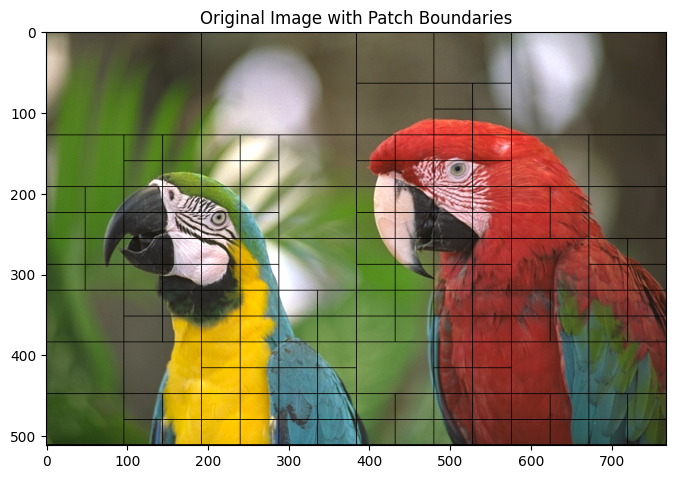

Original Resolution: 512 x 768
Adaptive Patch enabled : True
Encoding with codebook...
Using codebook: Codebook/adaptive_patching_codebook_4d_512clusters_mst.npy
tensor(1.3418)
tensor(-0.4520)
tensor(0.9476)
tensor(-1.2648)
Encoded feature saved to ./Binary/indices.bin
Noisy data written to ./Binary/noisy.bin (Eb/N0=2.0 dB)
Files patch_coords.bin and ./Binary/noisy.bin combined into ./Binary/simulated.bin with metadata.
Original image size: 544.53 KB
Binary file size for transmission: 12.00 KB
Compression Ratio (Original / Transmitted): 45.37


In [14]:
datasets = {
    'k': {'name': 'Kodak', 'path': 'Datasets/Kodak/kodim'},
    'c': {'name': 'Clic', 'path': 'Datasets/Clic2021/'},
    'd': {'name': 'DIV2K', 'path': 'Datasets/DIV2K/DIV2K_valid_HR/'},
    'g': {'name': 'General', 'path': 'Datasets/General/'},
    'w': {'name': 'Wildlife', 'path': 'Datasets/Wildlife/'},
    'f': {'name': 'Faces', 'path': ''}
}

# Arguments

dataset_letter = 'k'  # Choose from 'k', 'c', 'd', or 'g'
img_no = '23'

use_codebook = True                      # Set to False if you don't want to use codebook
adaptive = None                           # Set to "true", "false", or None (None will auto-detect based on threshold) 
k = 512
chunk_size = 4

awgn_noise = 2.0 

patch_size = 28   # 60 or 28
low_th = 100
high_th = 200
v_val = 100
depth = 7
kernel=1


dataset = datasets[dataset_letter]['name']
image_path = f"{datasets[dataset_letter]['path']}{img_no}.png"

# --- Set codebook paths based on chunk_size and k ---
key = (chunk_size, k)
codebook_path_adaptive = codebook_paths[key]["adaptive"]
codebook_path_wo_adaptive = codebook_paths[key]["wo_adaptive"]

# --- Call main function directly ---
# transmit_code(dataset, image_path, img_no, use_codebook, adaptive, awgn_noise)
transmit_code(dataset, image_path, img_no , use_codebook, adaptive, awgn_noise, patch_size, low_th, high_th, v_val, depth, kernel)

File ./Binary/simulated.bin split into patch_coord_received.bin and image_data_received.bin.
Adaptive Patching Enabled: True
Using codebook: Codebook/adaptive_patching_codebook_4d_512clusters_mst.npy
Resolution read from file: 512x384


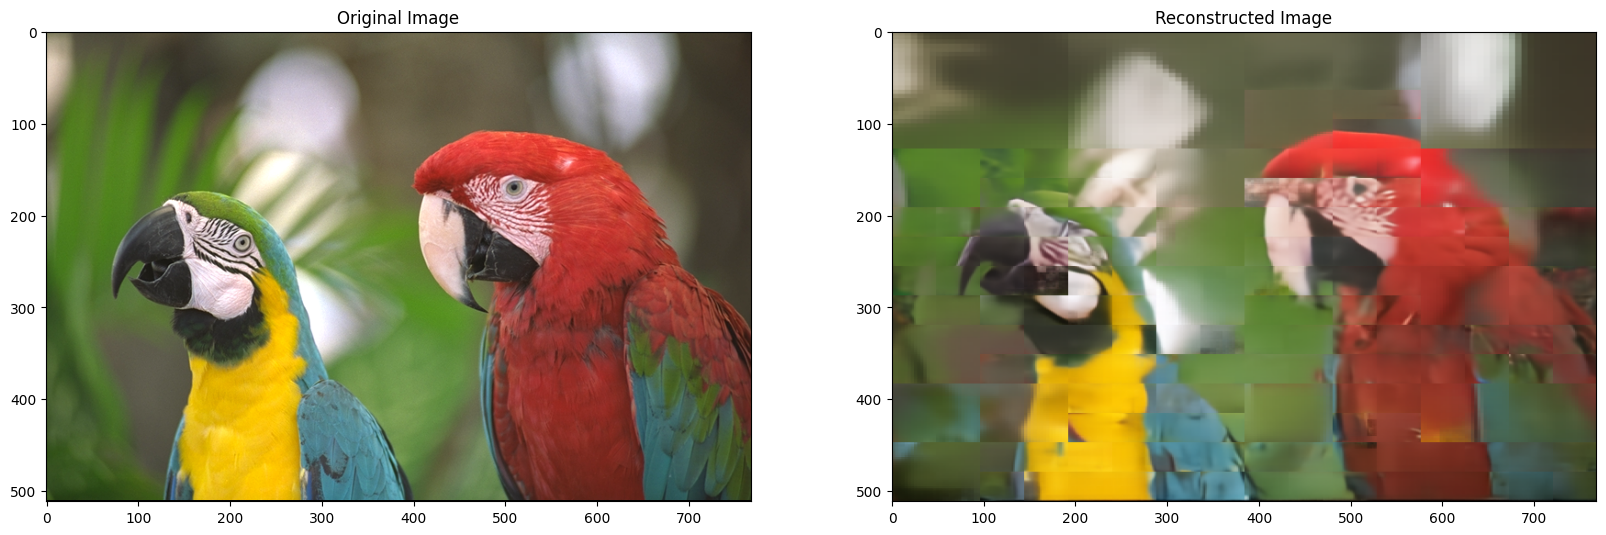

Output image path: ./recon/simulated_image.png
Channel Bandwidth Ratio: 0.005208333333333333
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Python311\cv\Lib\site-packages\lpips\weights\v0.1\alex.pth
PSNR: 22.335 dB
MS-SSIM: 0.7991
LPIPS: 0.3626
Input Image Size: 544.53 KB
Transmitted Binary Size: 12.00 KB
Compression Ratio: 45.37


In [15]:

# --- Get codebook paths ---
key = (chunk_size, k)
codebook_path_adaptive = codebook_paths[key]["adaptive"]
codebook_path_wo_adaptive = codebook_paths[key]["wo_adaptive"]


received_file = "./Binary/simulated.bin"

receive_code(received_file, dataset, img_no, image_path, use_codebook)
